In [1]:
import itertools
import json
from abc import ABC, abstractmethod
from pathlib import Path
from timeit import default_timer as timer
from typing import List, Union, Tuple

import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import numpy as np
from PIL import Image, ImageFilter
from sklearn.neighbors import KDTree
from skimage import metrics
from tqdm import tqdm


In [2]:
def timeit(func):
    """
    Function decorator to time the execution of a function
    """
    def wrapper(*args, **kwargs):
        start = timer()
        result = func(*args, **kwargs)
        end = timer()
        print(f"{func.__name__} took {end - start:.2f} seconds")
        return result

    return wrapper

<h2> Klassen zu Umsetzung der Colormaps </h2>

In [3]:
# Der Allgemeine Gedanke hinter diesem Ansatz ist es, dass wir Pixel ersetzen. Pixel sind nicht wie Bilder ein komplexes Objekt aus vielen Farben, die zusammen einen Sinn ergeben. Ein Pixel ist nur eine Farbe. 
# Gerade wenn man wie in diesem Fall vorwiegend mit Bildern arbeitet, die eine geringe Auflösung haben, dann liegt die Idee nahe, dass man Bilder finden möchte, die genau die gleiche Farbe haben. Aus diesem 
# Gedanken heraus entstand die Idee der Farbquantisierung und der Farbpaletten. Man verwendet eine Farbpalette, die möglichst viele Farben enthält, damit die Bilder trotz der Quantisierung möglichst gut
# dargestellt werden können. Dann durchsucht man den Datensatz nach Bildern, die die entsprechenden Colorcode haben. Wenn ein Bild mit einem hohen Prozentsatz den entsprechenden Colorcode hat, dann repräsentiert
# er die Farben des Pixels gut, da dieser ja zu 100% die Farbe besitzt (unter berücksichtigung der Quantisierung).

# !!!! Work on a new approach to find the nearest color code (maybe by distance) !!!!

class ColorMap:
    def __init__(self):
        self.hue_bins = None
        self.sat_bins = None
        self.val_bins = None
        self.bin_edges_hue = None
        self.bin_edges_sat = None
        self.bin_edges_val = None
        
        self.colors = None
        self.color_codes = None
        self.color_dictionary = {}
        self.kd_tree = None
        self.combined_color_codes = {}

    @abstractmethod
    def _initialize_color_codes(self) -> List[np.ndarray]:
        """
        The function uses the informations about the bin sizes and calculates the colors 
        as well as the color codes for the color map. The color codes are unique for each
        color.
        Returns:
            colors: A 2D numpy array of colors in the HSV color space
            color_codes: A 1D numpy array of color codes
        """
    
    @abstractmethod
    def calculate_color_code(
        self, 
        pixels: np.ndarray
    ) -> np.ndarray:
        """
        The function should take a numpy array of pixels (h, s, v) and convert them to color code
        for each pixel in the pixel array. The color codes are dependent on the color map and should
        be unique for each pixel in the pixel array.\n
        Args:
            pixels: A numpy array of pixels in the HSV color space
        Returns:
            color_codes: A 1D numpy array of color codes
        """

    def calculate_color_from_code(self, color_codes: Union[np.ndarray, int]):
        """
        Calculate the color as a 3-tuple (H, S, V) from the color code.\n 
        Args:
            color_codes: A numpy array of color codes or a single color code
        Returns:
            colors_per_pixel: A numpy array of colors in the HSV color space
        """
        if isinstance(color_codes, int):
            color_codes = np.array([color_codes])
        if isinstance(color_codes, np.int_):
            color_codes = np.array([color_codes]).astype(int)
        if not isinstance(color_codes, np.ndarray):
            raise ValueError("color_codes should be a numpy array")
        if all(color_codes < 0) or all(
            color_codes > (self.hue_bins * self.sat_bins * self.val_bins) - 1
        ):
            raise ValueError(
                "Color code must be in the range [0, BINS_HUE * BINS_SAT * BINS_VAL - 1]"
            )

        hue_bin = color_codes % self.hue_bins
        saturation_bin = (color_codes // self.hue_bins) % self.sat_bins
        value_bin = (color_codes // (self.hue_bins * self.sat_bins)) % self.val_bins

        hue = self.bin_edges_hue[hue_bin]
        sat = self.bin_edges_sat[saturation_bin]
        val = self.bin_edges_val[value_bin]

        colors_per_pixel = np.array([hue, sat, val]).T
        return colors_per_pixel

    def create_color_map_auto(
        self, 
        hue_bins: int, 
        sat_bins: int, 
        val_bins: int
    ) -> None:
        """
        The function creates a color map with the given number of bins for the
        hue, saturation and value channel. The function uses the _initialize_color_codes
        function to calculate the color codes and colors for the color map.\n
        Args:
            hue_bins: The number of bins for the hue channel
            sat_bins: The number of bins for the saturation channel
            val_bins: The number of bins for the value channel
        """
        self.hue_bins = hue_bins
        self.sat_bins = sat_bins
        self.val_bins = val_bins
        colors, color_codes = self._initialize_color_codes()
        colors_sort, color_codes_sort = zip(
            *sorted(zip(colors, color_codes), key=lambda x: x[1])
        )
        self.kd_tree = KDTree(colors_sort)
        self.colors = np.array(colors_sort)
        self.color_codes = np.array(color_codes_sort)
        self.color_dictionary = dict(zip(color_codes_sort, colors_sort))

    def _check_pixel_input(self, pixels: np.ndarray):
        """
        This helper function checks if the pixel input is a numpy array and
        if the pixel input has the correct shape. The function raises a ValueError
        if the pixel input is not a numpy array or if the shape of the pixel input
        is not correct.
        Args:
            pixels: A numpy array of pixels in the HSV color space
        """
        if not isinstance(pixels, np.ndarray):
            raise ValueError("pixels should be a numpy array")
        if not pixels.shape[-1] == 3:
            raise ValueError("Pixel must be a 3-tuple (H, S, V)")
        if not all(pixels[:, 0] >= 0) or not all(pixels[:, 0] <= 360):
            raise ValueError(f"Hue must be in the range [0, 360]")
        if not all(pixels[:, 1] >= 0) or not all(pixels[:, 1] <= 1):
            raise ValueError(f"Saturation must be in the range [0, 1]")
        if not all(pixels[:, 2] >= 0) or not all(pixels[:, 2] <= 1):
            raise ValueError(f"Value must be in the range [0, 1]")

    def display_color_map(self, ordered: bool = True):
        """
        This function displays the color map in a grid. 
        If ordered is True, it optimizes the grid by removing empty rows and columns (combined color codes are removed from the grid)
        If ordered is False, it displays the color map without combined color codes, in an unordered grid.\n
        Args:
            ordered: Boolean to enable ordered display of the color map.
        """
        if ordered:
            self._display_pruned_color_map()
        else:
            self._display_odd_color_map()

    def _display_pruned_color_map(self):
        """
        This function displays the color map and removes all rows that have less than 3 colors in them.
        The removed colors are then displayed in the next row(s) until the number of colors in each row is at least 3.
        Furthermore, the function removes all empty columns from the grid.
        """
        # calculate the number of rows and columns is if all colors are displayed
        num_colors = len(self.color_dictionary)
        cols = self.hue_bins
        rows = int(np.ceil(num_colors / cols))
        self._sort_color_dictionary()
        color_codes = np.array(list(self.color_dictionary.keys()))

        # create a grid that contains -1 for color codes that are combined to others and the color code for the rest
        grid = np.full((rows, cols), -1)
        index = 0
        for i in range(rows):
            for j in range(cols):
                color_code = color_codes[index]
                if color_code in self.combined_color_codes.keys():
                    index += 1
                    continue
                grid[i, j] = color_code
                index += 1

        # find all rows that have less than 3 colors in them (colors that are not combined)
        colors_per_row = np.sum(grid != -1, axis=1)
        rows_to_remove = np.where(colors_per_row < 3)[0]

        # calculate the number of rows needed to display the removed colors (colors that are in rows with less than 3 colors in them)
        num_colors_less = np.sum(colors_per_row[rows_to_remove])
        if num_colors_less % self.hue_bins != 0:
            rows_needed = np.ceil(num_colors_less / self.hue_bins)
            rows += rows_needed

        # get all color codes that are in rows with less than 3 colors in them
        values_to_display_in_extra_rows = []
        for row_id in rows_to_remove:
            row = grid[row_id]
            row = row[row != -1]
            values_to_display_in_extra_rows.extend(row)

        # delete all rows that have less than 3 colors in them
        grid = np.delete(grid, rows_to_remove, axis=0)

        # delete all columns that are empty over all rows (only contain -1)
        colums_to_remove = np.where(np.all(grid == -1, axis=0))[0]
        grid = np.delete(grid, colums_to_remove, axis=1)
        cols = grid.shape[1]

        # add padding to the values that are displayed in an extra row and reshape the array to the number of columns
        if len(values_to_display_in_extra_rows) % cols != 0:
            padding = list(
                -1 for _ in range(cols - len(values_to_display_in_extra_rows) % cols)
            )
            values_to_display_in_extra_rows.extend(padding)
            values_to_display_in_extra_rows = np.array(values_to_display_in_extra_rows)

        # reshape the array to the number of columns and rows needed and add it to the grid
        if len(values_to_display_in_extra_rows) != 0:
            values_to_display_in_extra_rows = values_to_display_in_extra_rows.reshape(
                int(rows_needed), cols
            )
            grid = np.vstack([grid, values_to_display_in_extra_rows])

        # display the grid
        rows, cols = grid.shape
        _, axs = plt.subplots(rows, cols, figsize=(cols, rows))
        for i in range(rows):
            for j in range(cols):
                color_code = grid[i, j]
                if color_code == -1:
                    axs[i, j].axis("off")
                    continue
                color = self.color_dictionary[color_code]
                color = color / np.array([360, 1, 1])
                color = hsv_to_rgb(color)
                pixel_array = np.zeros((6, 6, 3))
                pixel_array[:, 0:6] = color
                axs[i, j].axis("off")
                axs[i, j].imshow(pixel_array, aspect="auto")
                axs[i, j].set_title(str(color_code))

        plt.tight_layout()
        plt.show()

    def _display_odd_color_map(self):
        """
        The function displays the color map in a grid. The number of rows and columns is calculated
        so that the grid is as square as possible. The grid has no order it only tries to display 
        all not combined color codes in the grid as good as possible.\n
        """
        num_colors = len(self.color_dictionary) - len(self.combined_color_codes)
        rows = int(np.sqrt(num_colors))
        cols = int(np.ceil(num_colors / rows))
        _, axs = plt.subplots(rows, cols, figsize=(cols, rows))

        self._sort_color_dictionary()
        colors = np.array(list(self.color_dictionary.values()))
        color_codes = np.array(list(self.color_dictionary.keys()))

        # remove combined color codes from the color codes and colors
        new_colors = []
        new_color_codes = []
        for i in range(len(colors)):
            if color_codes[i] not in self.combined_color_codes:
                new_colors.append(colors[i])
                new_color_codes.append(color_codes[i])

        # display the colors
        index = 0
        for i in range(rows):
            for j in range(cols):
                if index == len(new_colors):
                    axs[i, j].axis("off")
                    continue
                color = new_colors[index]
                color = color / np.array([360, 1, 1])
                color = hsv_to_rgb(color)
                pixel_array = np.zeros((6, 6, 3))
                pixel_array[:, 0:6] = color
                axs[i, j].axis("off")
                axs[i, j].imshow(pixel_array, aspect="auto")
                axs[i, j].set_title(new_color_codes[index])
                index += 1
        plt.tight_layout()
        plt.show()

    def _sort_color_dictionary(self):
        """
        This function sorts the color dictionary by the color codes.
        """
        self.color_dictionary = dict(sorted(self.color_dictionary.items()))

    def combine_color_codes(
        self, 
        color_codes: List[int], 
        combine_color_code: int
    ) -> None:
        """
        The function combines the color codes in the color map. The function takes a list of color codes
        and combines them to the given combine color code. Combining color codes means that the color code 
        will replace all color codes in the list of color codes. The function raises a ValueError if the
        combine color code is already a combined color code.\n
        Args:
            color_codes: A list of color codes that should be combined
            combine_color_code: The color code that replaces the color codes in the list of color codes
        """
        for code in color_codes:
            if code in self.combined_color_codes:
                raise ValueError(f"Color code {code} is already a combined color code")
            self.combined_color_codes[code] = combine_color_code

    # Hier muss es einen besseren Weg geben den nächsten Farbcode zu finden. Die Methode sollte unabhängig von der Menge der Hue, Saturation und Value Bins sein.
    def find_nearest_color_code(self, color_code, dataset_keys=None, debug=False):
        colors = np.array(list(self.color_dictionary.values()))
        # sinse their are more bins for hue, we need to weight saturation and value so that the distance is not dominated by hue
        # weigth the saturation and value bins by the number of hue bins so they have the same weight as the hue bins
        colors = colors / np.array([360, 1, 1])
        relative_sat = (
            self.hue_bins // self.sat_bins
        )  # 16 // 4 = 4  ---------- 16 // 3 = 5  -> muss das eine Integer Division sein?
        relative_val = self.hue_bins // self.val_bins
        colors_weighted = colors / np.array([1, relative_sat, relative_val])

        # apply the same weights to the color code that is checked for the nearest color code
        hsv = self.calculate_color_from_code(color_code)
        h = hsv[0][0] / 360
        s = hsv[0][1] / relative_sat
        v = hsv[0][2] / relative_val

        distances = []
        if debug:
            print(f"Debugging: {color_code}", flush=True)
        for i, color in enumerate(colors_weighted):
            hue_distance = min(abs(color[0] - h), 1 - abs(color[0] - h))
            sat_distance = abs(color[1] - s)
            val_distance = (
                abs(color[2] - v) * 1.2
            )  # increase the distance from the value so it get less important than hue and saturation
            distance = np.sqrt(hue_distance**2 + sat_distance**2 + val_distance**2)
            if debug:
                print(f"Colorcode {i} for searched color code {color_code}", flush=True)
            if debug:
                print(f"{color} - {np.array([h, s, v])} = {distance}", flush=True)
            distances.append(distance)
        distances = np.array(distances)
        if debug:
            print(f"Distances:\n {distances}", flush=True)
        nearest = np.argsort(distances)

        # replace codes that are combined with the combined code
        for combined_code, code in self.combined_color_codes.items():
            if combined_code in nearest:
                nearest[nearest == combined_code] = code

        # remove codes that are more than once in nearest and keep the first occurence but keep the order of nearest
        seen = set()
        nearest = np.array([x for x in nearest if x not in seen and not seen.add(x)])
        nearest = nearest[nearest != color_code]
        if debug:
            print(f"Nearest: {nearest}", flush=True)
        return nearest


class HistogramColorMap(ColorMap):
    def _initialize_color_codes(self) -> np.ndarray:
        """
        Function to initialize the color codes for the color map. 
        The function should take a numpy array of colors (h, s, v) and convert them to initial
        color codes which are based on the histogram approach. Each of the three channels 
        (hue, saturation, value) should be divided into a number of bins. The boundaries of the 
        channels are not directly included in the bins but there are indirect in the last bin 
        included. 
        Args:
            colors: A numpy array of colors in the HSV color space
        Returns:
            color_codes: A 1D numpy array of color codes
        """
        self.bin_edges_hue = np.linspace(0, 360, self.hue_bins, endpoint=False)
        self.bin_edges_sat = np.linspace(0, 1, self.sat_bins, endpoint=False)
        self.bin_edges_val = np.linspace(0, 1, self.val_bins, endpoint=False)


        colors = np.array(
            np.meshgrid(self.bin_edges_hue, self.bin_edges_sat, self.bin_edges_val)
        ).T.reshape(-1, 3)
        color_codes = self.calculate_color_code(colors)
        return colors, color_codes
    
    def calculate_color_code(self, pixels: np.ndarray):
        self._check_pixel_input(pixels)
        hue_bin_num = np.digitize(pixels[:, 0], self.bin_edges_hue) - 1
        sat_bin_num = np.digitize(pixels[:, 1], self.bin_edges_sat) - 1
        val_bin_num = np.digitize(pixels[:, 2], self.bin_edges_val) - 1

        color_codes = (
            hue_bin_num
            + (self.hue_bins * sat_bin_num)
            + (self.hue_bins * self.sat_bins * val_bin_num)
        )
        
        if self.combined_color_codes != {}:
            for code in self.combined_color_codes:
                mask = color_codes == code
                color_codes[mask] = self.combined_color_codes[code]

        return color_codes

class StandardColorMap(ColorMap):
    def _initialize_color_codes(self) -> np.ndarray:
        self.bin_edges_hue = np.linspace(0, 360, self.hue_bins, endpoint=False)
        self.bin_edges_sat = np.linspace(0, 1, self.sat_bins, endpoint=False)
        self.bin_edges_val = np.linspace(0, 1, self.val_bins, endpoint=False)

        colors = np.array(
            np.meshgrid(self.bin_edges_hue, self.bin_edges_sat, self.bin_edges_val)
        ).T.reshape(-1, 3)
        color_codes = self._create_codes_for_colors(colors)
        return colors, color_codes
    
    def calculate_color_code(self, pixels: np.ndarray):
        """
        This function calculates the color code for each pixel in the pixel array.
        The color code is unique for each pixel in the pixel array. The pixel must 
        be in the HSV color space.\n
        Args:
            pixels: A numpy array of pixels in the HSV color space
        """
        self._check_pixel_input(pixels)
        _, nearest_indices = self.kd_tree.query(pixels)
        # nearest_indices = nearest_indices.flatten()
        nearest_codes = self.color_codes[nearest_indices]

        if self.combined_color_codes != {}:
            for code in self.combined_color_codes:
                mask = nearest_codes == code
                nearest_codes[mask] = self.combined_color_codes[code]

        return nearest_codes
    
    def _create_codes_for_colors(self, colors: np.ndarray) -> np.ndarray:
        """
        Calculates the initial color code for each color in the colormap using the HSV color space.
        param pixels: A numpy array of shape (n, 3) representing n pixels in the HSV color space
        return: A numpy array of color codes
        """
        hue_bin_num = np.digitize(colors[:, 0], self.bin_edges_hue) - 1
        sat_bin_num = np.digitize(colors[:, 1], self.bin_edges_sat) - 1
        val_bin_num = np.digitize(colors[:, 2], self.bin_edges_val) - 1

        color_codes = (
            hue_bin_num
            + (self.hue_bins * sat_bin_num)
            + (self.hue_bins * self.sat_bins * val_bin_num)
        )
        return color_codes
           
class DistanceColorMap(ColorMap):
    def _initialize_color_codes(self):
        if self.sat_bins == 1:
            self.bin_edges_sat = np.array(
                [1]
            )  # if there is only one bin for saturation, the bin edge is 1
        else:
            self.bin_edges_sat = np.linspace(
                0, 1, self.sat_bins, endpoint=True if self.sat_bins != 1 else False
            )

        if self.val_bins == 1:
            self.bin_edges_val = np.array([1])
        else:
            self.bin_edges_val = np.linspace(
                0, 1, self.val_bins, endpoint=True if self.val_bins != 1 else False
            )

        self.bin_edges_hue = np.linspace(0, 360, self.hue_bins, endpoint=False)
        
        colors = np.array(
            np.meshgrid(self.bin_edges_hue, self.bin_edges_sat, self.bin_edges_val)
        ).T.reshape(-1, 3)

        color_codes = self._create_codes_for_colors(colors)
        return colors, color_codes

    def calculate_color_code(self, pixels: np.ndarray) -> np.ndarray:
        self._check_pixel_input(pixels)
        _, nearest_indices = self.kd_tree.query(pixels)
        nearest_indices = nearest_indices.flatten()
        nearest_codes = self.color_codes[nearest_indices]

        if self.combined_color_codes != {}:
            for code in self.combined_color_codes:
                mask = nearest_codes == code
                nearest_codes[mask] = self.combined_color_codes[code]

        return nearest_codes

    def _create_codes_for_colors(self, colors: np.ndarray) -> np.ndarray:
        """
        Calculates the initial color code for each color in the colormap using the HSV color space.
        param pixels: A numpy array of shape (n, 3) representing n pixels in the HSV color space
        return: A numpy array of color codes
        """
        hue_bin_num = np.digitize(colors[:, 0], self.bin_edges_hue) - 1
        sat_bin_num = np.digitize(colors[:, 1], self.bin_edges_sat) - 1
        val_bin_num = np.digitize(colors[:, 2], self.bin_edges_val) - 1

        color_codes = (
            hue_bin_num
            + (self.hue_bins * sat_bin_num)
            + (self.hue_bins * self.sat_bins * val_bin_num)
        )
        return color_codes

class SpecialColorMap838(DistanceColorMap):
    def _initialize_color_codes(self):
        self.hue_bins = 8
        self.sat_bins = 3
        self.val_bins = 8
        return super()._initialize_color_codes()

    def calculate_color_code(self, pixels: np.ndarray) -> np.ndarray:
        return super().calculate_color_code(pixels)

    def find_nearest_color_code(self, color_code, datasets_keys = None, debug=False):
        """
        Overrides the find_nearest_color_code function of the DistanceColorMap class. 
        """
        if datasets_keys is None:
            raise ValueError("The datasets_keys must be provided for this color map")
        color_code = color_code[0]
        hue_bin_code = color_code % self.hue_bins
        sat_bin_code = (color_code // self.hue_bins) % self.sat_bins
        val_bin_code = (color_code // (self.hue_bins * self.sat_bins)) % self.val_bins

        # get all hue value codes
        list_hues = [i for i in range(8)]
        start_index = list_hues.index(hue_bin_code)
        alternating_list = [hue_bin_code]
        index_counter_plus = start_index
        index_counter_minus = start_index
        for _ in range(len(list_hues)//2):
            index_counter_minus = (index_counter_minus - 1)
            if index_counter_minus == -1:
                index_counter_minus = len(list_hues) - 1
            alternating_list.append(list_hues[index_counter_minus])
            
            index_counter_plus = (index_counter_plus + 1) 
            if index_counter_plus == len(list_hues):
                index_counter_plus = 0
            alternating_list.append(list_hues[index_counter_plus])
            
        if len(list_hues) % 2 != 1:
            alternating_list = alternating_list[:-1]
        # print(f"Alternating list: {alternating_list}")
        
        # Calculate color codes from the alternating list
        color_code_list = []
        for hue in alternating_list:
            color_code_list.append(hue + (sat_bin_code * 8) + (val_bin_code * 24))
        # print(f"Color code list: {color_code_list}")

        if val_bin_code == 0:
            # first check all sat values then move left and right and check all sat values and so on
            code = self._calc_black(datasets_keys, color_code_list)
            if code == -1:
                
                # print("No black color code found, try in the color area")
                
                color_code_list = []
                value_bin_code = 1 # set value bin code to 1 to trigger color code calculation to find image
                for hue in alternating_list:
                    color_code_list.append(hue + ((sat_bin_code) * 8) + (value_bin_code * 24))
                    
                code = self._calc_colors(datasets_keys, color_code_list)
                if code == -1:
                    raise ValueError("No color code found")
                else:   
                    return np.array([code])
            else:
                return np.array([code])
        
        else:
            code = self._calc_colors(datasets_keys, color_code_list)
            if code == -1:
                # print("No color code found, try in the black area")
                color_code_list = []
                value_bin_code = 0 # set value bin code to 0 to trigger color code calculation to find image
                for hue in alternating_list:
                    color_code_list.append(hue + ((sat_bin_code) * 8) + (value_bin_code * 24))

                code = self._calc_black(datasets_keys, color_code_list)
                if code == -1:
                    raise ValueError("No color code found")
                else:
                    return np.array([code])
            else:
                return np.array([code])
            
    def _look_luminance_sat(
        self, 
        color_code: int,
        dataset_keys: list
    ):
        # print(f"Check Neigbourhood of color code {color_code}")
        val_bin_code = (color_code // (self.hue_bins * self.sat_bins)) % self.val_bins
        num_luminance_above = min(self.val_bins - val_bin_code, 3)
        num_luminance_below = min(val_bin_code, 3) # 1-3 in der Schleife nur 1-2 sind
        
        luminance_above_codes = [color_code + (i * 24) for i in range(1, num_luminance_above)]
        luminance_below_codes = [color_code - (i * 24) for i in range(1, num_luminance_below)]
        all_luminance_codes = []
        max_length = max(len(luminance_above_codes), len(luminance_below_codes))
        for i in range(max_length):
            if i < len(luminance_above_codes):
                all_luminance_codes.append(luminance_above_codes[i])
            if i < len(luminance_below_codes):
                all_luminance_codes.append(luminance_below_codes[i])
        
        # print(f"Luminance codes: {all_luminance_codes}")
        
        all_sat_codes = []
        sat_bin_code = (color_code // self.hue_bins) % self.sat_bins
        if sat_bin_code == 0:
            all_sat_codes.append(color_code)
        else:
            if sat_bin_code == 1:
                all_sat_codes.append(color_code)
                all_sat_codes.append(color_code + 8)
            else:
                all_sat_codes.append(color_code)
                all_sat_codes.append(color_code - 8)
            
        for code in all_sat_codes:
            # print(f"Checking color code {code}")
            if code in dataset_keys:
                return code
        
        for code in all_luminance_codes:
            # print(f"Checking color code {code}")
            if code in dataset_keys:
                return code

            all_sat_codes = []
            sat_bin_code = (code // self.hue_bins) % self.sat_bins
            if sat_bin_code == 0:
                continue
            else:
                if sat_bin_code == 1:
                    all_sat_codes.append(code + 8)
                else:
                    all_sat_codes.append(code - 8)
            
            for code in all_sat_codes:
                # print(f"Checking color code {code}")
                if code in dataset_keys:
                    return code
        
        return -1
                    
    def _look_all_luminance_sat(
        self, 
        color_code: int,
        dataset_keys: list
    ):
        # print(f"Check full Neigbourhood of color code {color_code}")
        val_bin_code = (color_code // (self.hue_bins * self.sat_bins)) % self.val_bins
        num_luminance_above = self.val_bins - val_bin_code
        num_luminance_below = val_bin_code
        
        luminance_above_codes = [color_code + (i * 24) for i in range(1, num_luminance_above)]
        luminance_below_codes = [color_code - (i * 24) for i in range(1, num_luminance_below)]
        all_luminance_codes = []
        max_length = max(len(luminance_above_codes), len(luminance_below_codes))
        for i in range(max_length):
            if i < len(luminance_above_codes):
                all_luminance_codes.append(luminance_above_codes[i])
            if i < len(luminance_below_codes):
                all_luminance_codes.append(luminance_below_codes[i])
        

        sat_bin_code = (color_code // self.hue_bins) % self.sat_bins
        num_sat_above = self.sat_bins - sat_bin_code
        num_sat_below = sat_bin_code
        
        sat_above_codes = [color_code + (i * 8) for i in range(1, num_sat_above)]
        sat_below_codes = [color_code - (i * 8) for i in range(1, num_sat_below+1)]
        all_sat_codes = [color_code]
        
        max_length = max(len(sat_above_codes), len(sat_below_codes))
        for i in range(max_length):
            if i < len(sat_above_codes):
                all_sat_codes.append(sat_above_codes[i])
            if i < len(sat_below_codes):
                all_sat_codes.append(sat_below_codes[i])
        
        for code in all_sat_codes:
            # print(f"Checking color code {code}")
            if code in dataset_keys:
                # print(f"Color code {code} found in dataset")
                return code
            
        
        for code in all_luminance_codes:
            # print(f"Checking color code {code}")
            if code in dataset_keys:
                # print(f"Color code {code} found in dataset")
                return code

            sat_above_codes = [code + (i * 8) for i in range(1, num_sat_above)]
            sat_below_codes = [code - (i * 8) for i in range(1, num_sat_below+1)]
            all_sat_codes = []
            
            max_length = max(len(sat_above_codes), len(sat_below_codes))
            for i in range(max_length):
                if i < len(sat_above_codes):
                    all_sat_codes.append(sat_above_codes[i])
                if i < len(sat_below_codes):
                    all_sat_codes.append(sat_below_codes[i])
            
            for code in all_sat_codes:
                # print(f"Checking color code {code}")
                if code in dataset_keys:
                    # print(f"Color code {code} found in dataset")
                    return code
        
        return -1
        
    def _look_all_sat(
        self,
        color_code: int,
        dataset_keys: list
    ):
        sat_bin_code = (color_code // self.hue_bins) % self.sat_bins
        num_sat_above = self.sat_bins - sat_bin_code
        num_sat_below = sat_bin_code
        
        sat_above_codes = [color_code + (i * 8) for i in range(1, num_sat_above)]
        sat_below_codes = [color_code - (i * 8) for i in range(1, num_sat_below+1)]
        all_sat_codes = [color_code]
        
        max_length = max(len(sat_above_codes), len(sat_below_codes))
        for i in range(max_length):
            if i < len(sat_above_codes):
                all_sat_codes.append(sat_above_codes[i])
            if i < len(sat_below_codes):
                all_sat_codes.append(sat_below_codes[i])
        
        for code in all_sat_codes:
            # print(f"Checking color code {code}")
            if code in dataset_keys:
                return code
        
        return -1
            
    def _calc_colors(
        self,
        datasets_keys: list,
        color_code_list: list
    ):
        for index in range(3):
            code = self._look_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(3):
            code = self._look_all_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(3, 6):
            code = self._look_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(3, 6):
            code = self._look_all_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        # Spezielle Methodeaufrufe
        for index in range(6, 8):
            code = self._look_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(6, 8):
            code = self._look_all_luminance_sat(color_code_list[index], datasets_keys)
            if code != -1: return code
            
        return -1
    
    def _calc_black(
        self,
        datasets_keys: list,
        color_code_list: list
    ):
        for index in range(3):
            code = self._look_all_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(3, 6):
            code = self._look_all_sat(color_code_list[index], datasets_keys)
            if code != -1: return code

        for index in range(6, 8):
            code = self._look_all_sat(color_code_list[index], datasets_keys)
            if code != -1: return code
            
        return -1
  
  
  
class ColorCoder:
    def __init__(self, color_map: ColorMap) -> None:
        self.color_map = color_map

    def calculate_quantized_image(
        self, image: np.ndarray, debug: bool = False
    ) -> np.ndarray:
        """
        function to calculate for each pixel in the image the new rgb value based on the color code of the pixel
        :param image: A numpy array of shape (h, w, rgb) representing the image
        :param debug: A boolean to enable debugging
        :return: A numpy array of shape (h, w, rgb) representing the quantized image
        """
        shape = image.shape
        image = rgb_to_hsv(image / 255.0) * np.array([360, 1, 1])
        image = image.reshape(-1, 3)

        color_codes = self.color_map.calculate_color_code(image)
        color = self.color_map.calculate_color_from_code(color_codes)

        color_rgb = hsv_to_rgb(color / np.array([360, 1, 1]))
        image = color_rgb.reshape(shape)
        return image

    def calculate_color_code_of_image(
        self, 
        image: np.ndarray, 
        threshold: float,
        debug: bool = False
    ) -> tuple[int, float]:
        """image as a numpy array of shape (h, w, rgb)"""
        if not isinstance(image, np.ndarray):
            raise ValueError("Image should be a numpy array")
        if image.shape[-1] == 4:
            print("Warning: Image has an alpha channel. Removing it.")
            image = image[:, :, :3]
        if image.shape[-1] == 1:
            print("Error: Image is a grayscale image. Please provide a color image.")
            return -1

        image = rgb_to_hsv(image / 255.0) * np.array([360, 1, 1])
        pixels = image.reshape(-1, 3)
        color_codes = self.color_map.calculate_color_code(pixels=pixels)
        values, counts = np.unique(color_codes, return_counts=True)

        if max(counts) / len(color_codes) < threshold:
            max_color_code = -1
            percentage = max(counts) / len(color_codes)
        else:
            max_color_code = values[np.argmax(counts)]
            percentage = max(counts) / len(color_codes)

        if debug:
            print(f"Debugging: {max_color_code}")
            print(f"Debugging: {list(zip(values, counts))}")

        return max_color_code, percentage

    def display_quantized_images(
        self,
        image_paths: list[Path],
        resize_dims: tuple = None,
        save: bool = False,
        outpath: Path = None,
        dpi: int = 400,
    ) -> None:
        fig, axs = plt.subplots(2, len(image_paths), figsize=(len(image_paths) * 4, 3))
        fig.suptitle(f"Quantized Images")
        for i, path in enumerate(image_paths):
            image = Image.open(path)
            if resize_dims:
                image = image.resize(resize_dims)
            image = np.array(image)
            axs[0, i].imshow(image)
            axs[0, i].axis("off")
            axs[1, i].imshow(self.calculate_quantized_image(image))
            axs[1, i].axis("off")

        if save and outpath is not None:
            filename = f"quantized_images.jpg"
            plt.savefig(outpath / filename, dpi=dpi)
        

In [4]:
standart_colormap = StandardColorMap()
standart_colormap.create_color_map_auto(8, 3, 8)

histogramm_colormap = HistogramColorMap()
histogramm_colormap.create_color_map_auto(8, 3, 8)

distance_colormap = DistanceColorMap()
distance_colormap.create_color_map_auto(8, 3, 8)

# small validation test for 8 hue bins, 3 saturation bins and 8 value bins
# 1. Test a h s v color and check if the color code is correct
# Histogramm/Standard bin edges for hue: [  0.  45.  90. 135. 180. 225. 270. 315.], for saturation: [0.  0.33 0.66], for value: [0.  0.125 0.25 0.375 0.5 0.625 0.75 0.875]
# Distance bin edges for hue: [ 0. 45. 90. 135. 180. 225. 270. 315.], for saturation: [0.  0.5  1], for value: [0. 0.143 0.286 0.429 0.571 0.714 0.857 1]
hsv1 = np.array([[0, 0, 0]])
erg1 = 0
assert standart_colormap.calculate_color_code(hsv1) == erg1
assert histogramm_colormap.calculate_color_code(hsv1) == erg1
assert distance_colormap.calculate_color_code(hsv1) == erg1

hsv2 = np.array([[360, 1, 1]])
erg2 = 191
assert standart_colormap.calculate_color_code(hsv2) == erg2
assert histogramm_colormap.calculate_color_code(hsv2) == erg2
assert distance_colormap.calculate_color_code(hsv2) == erg2

hsv3 = np.array([[44, 0, 0]])
erg3_dist = 1
erg3_hist = 0
erg3_stand = 1
assert standart_colormap.calculate_color_code(hsv3) == erg3_stand
assert histogramm_colormap.calculate_color_code(hsv3) == erg3_hist
assert distance_colormap.calculate_color_code(hsv3) == erg3_dist

hsv4 = np.array([[44, 0.34, 0.33]])
erg4_dist = 57
erg4_hist = 56
erg4_stand = 81
assert standart_colormap.calculate_color_code(hsv4) == erg4_stand
assert histogramm_colormap.calculate_color_code(hsv4) == erg4_hist
assert distance_colormap.calculate_color_code(hsv4) == erg4_dist

# 2. Create image of one color code and check if the color is correct
# rgb for [44, 0.34, 0.33] is [84, 77, 56]
image = np.zeros((10, 10, 3))
image[:, :, 0] = 84
image[:, :, 1] = 77
image[:, :, 2] = 56
erg_dist = 57
erg_hist = 56
erg_stand = 81

standart_coder = ColorCoder(standart_colormap)
histogramm_coder = ColorCoder(histogramm_colormap)
distance_coder = ColorCoder(distance_colormap)

code, _ = standart_coder.calculate_color_code_of_image(image, 0.5)
assert code == erg_stand
code, _ = histogramm_coder.calculate_color_code_of_image(image, 0.5)
assert code == erg_hist
code, _ = distance_coder.calculate_color_code_of_image(image, 0.5)
assert code == erg_dist

# 3. Create image with 2 color codes and check if the color is correct
# rgb for [44, 0.34, 0.33] is [84, 77, 56]
# rgb for [360, 1, 1] is [255, 0, 0]
image = np.zeros((10, 10, 3))
image[:, :, 0] = 84
image[:, :, 1] = 77
image[:, :, 2] = 56
image[6:, :, 0] = 255
image[6:, :, 1] = 0
image[6:, :, 2] = 0
erg_dist = 57
erg_hist = 56
erg_stand = 81

code, _ = standart_coder.calculate_color_code_of_image(image, 0.3)
assert code == erg_stand
code, _ = histogramm_coder.calculate_color_code_of_image(image, 0.3)
assert code == erg_hist
code, _ = distance_coder.calculate_color_code_of_image(image, 0.3)
assert code == erg_dist

<h2> Klassen zu Erstellung von Datendateien </h2>
Die Datendateien beinhalten Metadaten und die Bilddaten. Die Metadaten sind von Klasse (als Fotomosaikmethode) zu Klasse unterschiedlichen und dienen dazu, dass herausgefunden werden kann, ob für eine bestimmte Konfiguration von Parametern bereits eine Datendatei existiert und demnach keine Neuberechnung notwendig ist. Die Bilddaten sind Dictionaries mit einem Key, der von der jeweiligen Klasse abhängt. Hierbei könnte es sich um einen RGB-Wert, Farbcode, usw. handeln. Für jeden dieser Keys gibt es Dictionaries mit einem Bildpfad die auf diesen Key zugeteilt sind. Darüber hinaus beinhalten die diese Dictionarys noch mögliche zusatzinformationen zu den Bildern des jeweiligen Dictionarys. 

In [5]:
class DataProcessor(ABC):
    def __init__(
        self,
        dataset_file_path: Path = None,
        resize_shape: list[int, int] = [32, 32],
    ):
        self.dataset_file_path = dataset_file_path
        self.resize_shape = resize_shape
        self.processor_signature = None
        self.meta_data = None

    @abstractmethod
    def _create_metadata(
        self,
        dataset_image_path: Union[None, str],
        generate_data_set: bool,
        augment: bool,
    ) -> None:
        """
        Function to create the metadata for the dataset file and stores it the instance attribute
        meta_data.\n
        Args:
            out_dir (Path): The directory where the dataset file should be saved.
            generate_data_set (bool): Whether a new directory should be created with the relevant and resized data.
            augment (bool): Whether the data should be augmented.
        """

    @abstractmethod
    def get_keys(self) -> np.ndarray:
        """
        Function to get all keys from the dataset file. The format of the keys
        depends on the concrete implementation.\n
        Args:
            None
        Returns:
            np.ndarray: The keys from the dataset file.
        """

    @abstractmethod
    def _process_single_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
        save_image: bool,
    ) -> dict:
        """
        Function to process a single image and return the data dictionary.\n
        Args:
            data (dict): The dictionary to append.
            image_path (Path): The path to the image.
            out_path (Path): The path to the output directory.
            save_image (bool): Whether the image should be saved in new directory or not.
        Returns:
            dict: The dictionary with the processed image.
        """
        
    @abstractmethod
    def _process_augmented_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
    ) -> dict:
        """
        Function to process an augmented image and return the data dictionary.\n
        Args:
            data (dict): The dictionary to append.
            image_path (Path): The path to the image.
            out_path (Path): The path to the output directory.
        Returns:
            dict: The dictionary with the processed image.
        """
        
    @abstractmethod
    def _sort_data_by_key(
        self,
        data: dict,
    ) -> dict:
        """
        Function to sort the data dictionary by the key.\n
        Args:
            data (dict): The dictionary to sort.
        Returns:
            dict: The sorted dictionary.
        """

    def _apply_data_augmentation(
        self,
        image: np.ndarray,
    ) -> List[np.ndarray]:
        """
        Function takes an image and applies data augmentation to it, by flipping it horizontally and vertically
        as well as rotating it by 90, 180 and 270 degrees. The function returns a list with the original image.
        Args:
            image (np.ndarray): The image to augment.
        Returns:
            List[np.ndarray]: The original image and the augmented images.
        """
        images = []
        original_image = image
        for _ in range(3):
            image = np.rot90(image)
            images.append(image)
        images.append(np.fliplr(original_image))
        return images

    def _check_datasetfile_path(self) -> None:
        """
        The function checks if the dataset file path is set and if the file exists.
        """
        if self.dataset_file_path is None:
            raise ValueError("No dataset file path provided.")
        if not self.dataset_file_path.exists():
            raise FileNotFoundError(f"Dataset file {self.dataset_file_path} not found.")

    def _check_existing_dataset_file(
        self,
        out_dir: Path,
    ) -> bool:
        """
        Function to check if a dataset file already exists in the output directory. If a dataset file already exists, it
        checks if there are any differences in the metadata. If one of the found files has the same metadata, the function
        returns set the dataset_file_path to the file path and returns False. If there are differences in all the found
        files, the function returns True.\n
        Args:
            out_dir (Path): The directory where the dataset file should be saved.
        Returns:
            bool: Whether the current dataset file should be created or not.
        """
        file_paths = out_dir.rglob(f"*{self.processor_signature}*.json")
        if file_paths is None:
            print(f"No dataset file found in {out_dir}.")
            return True

        for file_path in file_paths:
            file_metadata = self._load_metadata_from_file(file_path)
            
            matching_metadata = True
            
            for key, value in self.meta_data.items():
                # skip dataset_image_path as it is always different
                if key == "dataset_image_path":
                    continue
                if value != file_metadata[key]:
                    matching_metadata = False
                    break
            
            if matching_metadata:
                print(f"Dataset file with the same metadata found in {out_dir}.")
                self.dataset_file_path = file_path
                return False
            
        print(f"No dataset file with the same metadata found in {out_dir}.")
        return True

    def _generate_dataset_folder_path(
        self, 
        out_dir: Path
    ) -> Path:
        """
        Function to check if a dataset folder with the processor signature already exists in the output directory. If a dataset folder with the
        processor signature already exists, the function adds a number to the name and checks again.\n
        Args:
            out_dir (Path): The directory where the dataset folder should be saved.
        Returns:
            Path: The path to the dataset folder.
        """
        folder_paths = out_dir.rglob(f"*{self.processor_signature}*")
        if folder_paths is None:
            return out_dir / f"{self.processor_signature}_dataset"
        else:
            return out_dir / f"{self.processor_signature}_dataset_{len(list(folder_paths))}"

    def _generate_dataset_file_path(
        self,
        out_dir: Path, 
    ) -> None:
        """
        Function to check if a dataset file with the processor signature already exists in the output directory. If a dataset file with the
        processor signature already exists, the function adds a number to the name and checks again.\n
        Args:
            out_dir (Path): The directory where the dataset file should be saved.
        """
        file_paths = out_dir.rglob(f"*{self.processor_signature}*.json")
        if file_paths is None:
            self.dataset_file_path = (
                out_dir / f"{self.processor_signature}_dataset.json"
            )
        else:
            self.dataset_file_path = (
                out_dir
                / f"{self.processor_signature}_dataset_{len(list(file_paths))}.json"
            )

    def generate_dataset_file(
        self,
        data_dir: Path,
        out_dir: Path,
        generate_data_set: bool = False,
        augment: bool = False,
    ) -> None:
        """
        Function to generate a dataset file based on the data in the data directory.
        The dataset file is a json file that contains metadata as well as information
        about the data in the data directory. The data is stored in a dictionary with
        the average color of the image as the key and the file path and the standard
        deviation of the image as the value. The dictionary is then sorted by the standard
        deviation. To find an key in the dictionary, it is nessessary to convert the rgb
        values to an numpy array and then to a string.\n
        Args:
            data_dir (Path): The directory containing the data.
            out_dir (Path): The directory where the dataset file should be saved.
            generate_data_set (bool, optional): Whether a new directory should be created with the relevant and resized data. Defaults to False.
            augment (bool, optional): Whether the data should be augmented. Defaults to False and is only relevant if generate_data_set is True.
        """
        # create folder for dataset images
        dataset_image_path = None
        if generate_data_set:
            out_path = self._generate_dataset_folder_path(out_dir)
            dataset_image_path = str(out_path)
            
        self._create_metadata(
            dataset_image_path=dataset_image_path,
            generate_data_set=generate_data_set,
            augment=augment
        )
        
        # check if dataset file with this metadata already exists
        if not self._check_existing_dataset_file(out_dir):
            return
        else:
            self._generate_dataset_file_path(out_dir)
            if generate_data_set:
                out_path.mkdir(parents=True, exist_ok=True)

        data_image_paths = self._get_all_files_in_dir(data_dir)
        data = {}
        for image_path in tqdm(data_image_paths, desc="Process each image in data_dir"):

            if generate_data_set and augment:
                data = self._process_augmented_image(
                    data=data, 
                    image_path=image_path, 
                    out_path=out_path
                )
                
            elif generate_data_set:
                data = self._process_single_image(
                    data=data, 
                    image_path=image_path, 
                    out_path=out_path,
                    save_image=True
                )

            else:
                data = self._process_single_image(
                    data=data,
                    image_path=image_path,
                    out_path=None,
                    save_image=False
                )

        data = self._sort_data_by_key(data)

        json_dict = {"metadata": self.meta_data, "data": data}
        with open(self.dataset_file_path, "w", encoding="utf-8") as file:
            json.dump(json_dict, file, indent=4)

    def get_data(self, key: any = None) -> dict:
        """
        Function to load the data from the dataset file. The format of the data
        depends on the concrete implementation.\n
        Args:
            key (any): The key to get the data for. The dataformat of the key 
            depends on the datatype used in the dataset file.
        Returns:
            dict: The data from the dataset file.
        """
        self._check_datasetfile_path()
        
        with open(self.dataset_file_path, "r", encoding="utf-8") as file:
            json_dict = json.load(file)
            
        if key is None:
            return json_dict["data"]
        else:
            try:
                return json_dict["data"][key]
            except KeyError:
                return None

    def _get_all_files_in_dir(
        self,
        data_dir: Path,
    ) -> np.ndarray[Path]:
        """
        Function to get all files in a directory recursively.\n
        Args:
            data_dir (Path): The directory to search for files.
        Returns:
            np.ndarray[Path]: The file paths of all files in the directory.
        """
        return np.array(list(data_dir.rglob("*jpg")))

    def _load_metadata_from_file(self, file_path: Path) -> dict:
        """
        Function to load the metadata from a file. The metadata is expected to be in json format.\n
        Args:
            file_path (Path): The path to the file containing the metadata.
        Returns:
            dict: The metadata from the file.
        """
        if not file_path.exists():
            raise FileNotFoundError(f"Metadata file {file_path} not found.")
        if not file_path.suffix == ".json":
            raise ValueError(f"Metadata file {file_path} is not a json file.")

        try:
            with open(file_path, "r", encoding="utf-8") as file:
                metadata = json.load(file)["metadata"]

            if metadata is None:
                raise ValueError(f"Metadata file {file_path} is empty.")

            return metadata

        except json.JSONDecodeError as exc:
            raise ValueError(f"Metadata file {file_path} is not a valid json file.") from exc


class ColorCodePreprocessor(DataProcessor):
    """
    Class to generate a dataset file based on the color code of images in a directory. It takes all
    the images in the data directory and calculates the color code for each image. The color code is
    then used as the key in a dictionary and the corresponding value includes the file path and the
    probability of the color code. The dictionary is then sorted by the probability.\n

    The dataset file is in JSON format and contains metadata along with information about the images in the data directory.
    Data is stored in a dictionary where the color code serves as the key, and the corresponding value includes the file path
    and the probability of the color code. The dictionary is sorted based on the probability.
    
    This class also provides functionality to load the data and perform data augmentation. If wished, 
    the data can be augemented by flipping the images horizontally and vertically as well as rotating them by 90, 180 and 270 degrees.
    
    Attributes:
        threshold (float): The threshold to use for the color coder.
        color_coder (ColorCoder): The color coder to use for the color coding.
        dataset_file_path (Path, optional): The path to the dataset file. Defaults to None.
        resize_shape (list[int, int], optional): The shape to resize the images to. Defaults to [32, 32].
    
    Methods:
        get_keys: Function to get all keys from the dataset file. The keys are the color codes of the images in the dataset file.
        _create_metadata: Function to create the metadata for the dataset file and stores it the instance attribute meta_data.
        _process_single_image: Function to process a single image and return the data dictionary.
        _process_augmented_image: Function to process an augmented image and return the data dictionary.
        _sort_data_by_key: Function to sort the data dictionary by the key color code.
    """
    def __init__(
        self, 
        threshold: float,
        color_coder: ColorCoder,
        dataset_file_path: Path = None,
        resize_shape: list[int, int] = [32, 32],
    ):
        """
        Initalizes the ColorCodePreprocessor class.\n
        Args:
            threshold (float): The threshold to use for the color coder.
            color_coder (ColorCoder): The color coder to use for the color coding.
            dataset_file_path (Path, optional): The path to the dataset file. Defaults to None.
            resize_shape (list[int, int], optional): The shape to resize the images to. Defaults to [32, 32].
        """
        super().__init__(dataset_file_path, resize_shape)
        self.processor_signature = "colorcode"
        self.threshold = threshold 
        self.color_coder = color_coder
         
    def get_keys(self) -> np.ndarray:
        self._check_datasetfile_path()
        
        with open(self.dataset_file_path, "r", encoding="utf-8") as file:
            json_dict = json.load(file)
        
        keys = [int(num) for num in json_dict["data"].keys()]
        return np.array(keys)
        
    def _create_metadata(
        self,
        dataset_image_path: Union[None, str],
        generate_data_set: bool,
        augment: bool
    ) -> None:
        """
        Function to create the metadata for the dataset file and stores it the instance attribute
        meta_data.\n
        Args:
            out_dir (Path): The directory where the dataset file should be saved.
            generate_data_set (bool): Whether a new directory should be created with the relevant and resized data.
            augment (bool): Whether the data should be augmented.
        """
        self.meta_data = {
            "resize_dims": self.resize_shape,
            "generate_data_set": generate_data_set,
            "dataset_image_path": dataset_image_path,
            "augment": augment,
            "threshold": self.threshold,
            "num_hue_bins": self.color_coder.color_map.hue_bins,
            "num_saturation_bins": self.color_coder.color_map.sat_bins,
            "num_value_bins": self.color_coder.color_map.val_bins,
            "combined_color_codes": self.color_coder.color_map.combined_color_codes
        }

    def _process_single_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
        save_image: bool,
    ) -> dict:
        image = Image.open(image_path)
        image = image.resize(self.resize_shape)
        image = np.array(image)
        
        if save_image:
            image_path = out_path / f"{image_path.stem}.jpg"
            temp = Image.fromarray(image)
            temp.save(image_path)
        
        code, probability = self.color_coder.calculate_color_code_of_image(image, self.threshold)
        
        if code == -1: 
            return data
        
        data.setdefault(int(code), []).append(
            {
                "image_path": str(image_path),
                "probability": probability
            }
        )
        
        return data
    
    def _process_augmented_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
    ) -> dict:
        image = Image.open(image_path)
        image = image.resize(self.resize_shape)
        image = np.array(image)
        
        images = self._apply_data_augmentation(image)
        images.append(image)
        
        for i, img in enumerate(images):
            augmented_image_path = out_path / f"{image_path.stem}_{i}.jpg"
            code, probability = self.color_coder.calculate_color_code_of_image(img, self.threshold)
            
            if code == -1: 
                continue
            
            data.setdefault(int(code), []).append(
                {
                    "image_path": str(augmented_image_path),
                    "probability": probability
                }
            )
            
            img = Image.fromarray(img)
            img.save(out_path / f"{image_path.stem}_{i}.jpg")
        
        return data

    def _sort_data_by_key(
        self,
        data: dict,
    ) -> dict:
        """
        Function to sort the data dictionary by the key color code.\n
        Args:
            data (dict): The dictionary to sort.
        Returns:
            dict: The sorted dictionary.
        """
        for key, value in data.items():
            sorted_list = sorted(value, key=lambda x: x["probability"], reverse=True)
            data[key] = sorted_list
        return data


class AveragePreprocessor(DataProcessor):
    """
    Preprocessor class for generating a dataset file based on the average color of images in a directory.

    The dataset file is in JSON format and contains metadata along with information about the images in the data directory. 
    Data is stored in a dictionary where the average color of the image serves as the key, and the corresponding value includes 
    the file path and the standard deviation of the image. The dictionary is sorted based on the standard deviation.

    This class also provides functionality to load the data and perform data augmentation.   
    """
    def __init__(
        self,
        dataset_file_path: Path = None,
        resize_shape: list[int, int] = [32, 32],
    ):
        super().__init__(dataset_file_path, resize_shape)
        self.processor_signature = "average"

    def get_keys(self) -> np.ndarray:
        """
        Function to get all keys from the dataset file. The keys are the average
        color of the images in the dataset file.\n
        Args:
            None
        Returns:
            np.ndarray: The keys from the dataset file.
        """
        self._check_datasetfile_path()

        with open(self.dataset_file_path, "r", encoding="utf-8") as file:
            json_dict = json.load(file)

        rgb_keys = list(json_dict["data"].keys())
        rgb_keys = np.array(
            [
                np.array([int(num) for num in string.strip("[]").split()])
                for string in rgb_keys
            ]
        )
        return rgb_keys

    def _create_metadata(
        self,
        dataset_image_path: Union[None, str],
        generate_data_set: bool,
        augment: bool,
    ) -> None:
        """
        Function to create the metadata for the dataset file and stores it the instance attribute
        meta_data.\n
        Args:
            out_dir (Path): The directory where the dataset file should be saved.
            generate_data_set (bool): Whether a new directory should be created with the relevant and resized data.
            augment (bool): Whether the data should be augmented.
        """
        self.meta_data = {
            "resize_dims": self.resize_shape,
            "generate_data_set": generate_data_set,
            "dataset_image_path": dataset_image_path,
            "augment": augment
        }
    
    def _process_single_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
        save_image: bool,
    ) -> dict:
        """
        Function to process a single image by calculating the average color and standard deviation
        of the image. The function appends the data dictionary with the average color and standard deviation
        of the image and returns the dictionary.\n
        Args:
            data (dict): The dictionary to append.
            image_path (Path): The path to the image.
            out_path (Path): The path to the output directory.
        Returns:
            dict: The dictionary with the average color and standard deviation of the image.
        """
        image = Image.open(image_path)
        image = image.resize(self.resize_shape)
        image = np.array(image)
        
        if save_image:
            image_path = out_path / f"{image_path.stem}.jpg"
            temp = Image.fromarray(image)
            temp.save(image_path)
        
        data = self._calculate_average_std_of_image(
            data=data, image=image, image_path=image_path
        )
        
        return data
    
    def _process_augmented_image(
        self,
        data: dict,
        image_path: Path,
        out_path: Path,
    ) -> dict:
        """
        Function to process an image by applying data augmentation to it and then calculating the average color and standard deviation
        of the image itself and the augmented images. The function appends the data dictionary with the average color and standard deviation
        of the image and the augmented images and returns the dictionary.\n
        Args:
            data (dict): The dictionary to append.
            image_path (Path): The path to the image.
            out_path (Path): The path to the output directory.
        Returns:
            dict: The dictionary with the average color and standard deviation of the image and the augmented images.
        """
        image = Image.open(image_path)
        image = image.resize(self.resize_shape)
        image = np.array(image)
        images = self._apply_data_augmentation(image)
        images.append(image)
        
        for i, img in enumerate(images):   
            augmented_image_path = out_path / f"{image_path.stem}_{i}.jpg"
                                 
            data = self._calculate_average_std_of_image(
                data=data, 
                image=img, 
                image_path=augmented_image_path
            )
            
            img = Image.fromarray(img)
            img.save(out_path / f"{image_path.stem}_{i}.jpg")
                    
        return data
    
    def _sort_data_by_key(
        self,
        data: dict,
    ) -> dict:
        """
        Function to sort the data dictionary by the key standart_deviation.\n
        Args:
            data (dict): The dictionary to sort.
        Returns:
            dict: The sorted dictionary.
        """
        for key, value in data.items():
            sorted_list = sorted(value, key=lambda x: x["standart_deviation"])
            data[key] = sorted_list
        return data

    def _calculate_average_std_of_image(
        self,
        data: dict,
        image_path: Path,
        image: np.ndarray,
    ) -> dict:
        """
        Function to calculate the average color and standard deviation of the images in the image_paths. Then
        the function saves the average color and standard deviation in a dictionary with the image path as the key
        and gives the dictionary back.\n
        Args:
            image_name (str): The name of the image.
            image (np.ndarray): The image to calculate the average color and standard deviation of. The
            image should be resized already.
        Returns:
            dict: The dictionary with the image path as the key and the average color and standard deviation as the value.
        """
        avg_r = round(np.mean(image[:, :, 0]), -1).astype(int)
        avg_g = round(np.mean(image[:, :, 1]), -1).astype(int)
        avg_b = round(np.mean(image[:, :, 2]), -1).astype(int)
        avg_r = np.clip(avg_r, 0, 255)
        avg_g = np.clip(avg_g, 0, 255)
        avg_b = np.clip(avg_b, 0, 255)
        std_r = round(np.std(image[:, :, 0]), -1)
        std_g = round(np.std(image[:, :, 1]), -1)
        std_b = round(np.std(image[:, :, 2]), -1)
        std = std_r + std_g + std_b

        if std > 180:
            return data

        key = str(np.array([avg_r, avg_g, avg_b]))
        information = {
            "image_path": str(image_path),
            "standart_deviation": std,
        }

        data.setdefault(key, []).append(information)
        return data

<h2> Klassen zur Erstellung der Fotomosaike </h2>

In [6]:
class MosaikGenerator(ABC):
    """
    The MosaikGenerator class is an abstract base class and is used 
    to as overclass for certain MosaikGenerator classes. It provides 
    some basic functionality to create mosaic images for a given image
    and data. It defines important abstract methods that have to be
    implemented by the subclasses. 
    
    Attributes:
        num_chunks (int): Number of chunks to split the image into for better performance
        crop_size (tuple): Size of the small images used in the mosaic
        radius (int): Radius in pixels in which no image should be repeatedly used
        data_processor (DataProcessor): DataProcessor object
    
    Methods:
        create_mosaic_image: Function to create mosaic images for a given image and data
        _perform_color_correction: Function to perform color correction on an image
        _is_image_used_within_distance: Function to find the first available path of an image that havent been
        used in the neighbourhood of the given radius around the current position
        _show_images: Function to show image data
        _save_images: Function to save the mosaic image to a certain path with a certain name
    
    """
    
    def __init__(self, data_processor: DataProcessor):
        """
        Initialization function for the MosaikGenerator class. Mainly 
        porpuse is to by called as super().__init__ in the subclasses.\n
        """
        self.num_chunks = 12
        self.crop_size = (16, 16)
        self.radius = 2
        self.data_processor = data_processor

 
    @abstractmethod
    def _get_sorted_image_paths_for_pixel(
        self, 
        rgb_information: np.ndarray
    ) -> List[List[Path]]:
        """
        Function to get sorted image paths for a pixel.\n
        Args:
            rgb_information (np.ndarray): RGB information of the all pixels in shape (n, 3)
        Returns:
            List[List[Path]]: Sorted list of image paths for each pixel
        """

    def create_mosaic_image(
        self,
        image_paths: Union[Path, List[Path], str, List[str]], 
        color_correction: float,
        out_dir_path: Union[Path, str],
        save_images: bool = False,
        show_images: bool = False,
    ) -> List[np.ndarray]:
        """
        Function to create mosaic images for a given image and data.\n
        Args:
            image_paths (Union[Path, List[Path], str, List[str]]): Path to the image(s)
            out_dir_path (Union[str, Path]): Path to the output directory
            color_correction (float): Color correction factor
            save_images (bool): Flag to save images
            show_images (bool): Flag to show images
        Returns:
            List[np.ndarray]: Mosaic image(s)
        """
        if isinstance(image_paths, (Path, str)):
            image_paths = [image_paths]
        if isinstance(image_paths, list):
            if isinstance(image_paths[0], str):
                image_paths = [Path(image) for image in image_paths]
        if isinstance(out_dir_path, str):
            out_dir_path = Path(out_dir_path)
        
        mosaic_images = []
        mosaic_image_stem = []
        
        for image_path in image_paths:
            
            original_image = Image.open(image_path)
            original_image = np.array(original_image)
        
            mosaic_image = self._initialize_mosaic_image(original_image.shape)

            remembered_images = self._initialize_remembered_images(original_image.shape)

            chunks = self._generate_data_chunks(image = original_image)

            mosaic_image = self._process_chunks(
                chunks=chunks,
                color_correction=color_correction,
                mosaic_image=mosaic_image,
                original_image_shape=original_image.shape,
                remembered_images=remembered_images,
            )

            if show_images:
                self._show_images(mosaic_image)
            
            mosaic_images.append(mosaic_image)
            mosaic_image_stem.append(image_path.stem)
        
    
        if save_images:
            self._save_images(
                image_names=mosaic_image_stem,
                image_data=mosaic_images,
                output_path=out_dir_path,
            )
        
        return mosaic_images

    def _generate_data_chunks(self, image: np.ndarray):
        """
        Function generates data chunks for an image\n
        Args:
            image (np.ndarray): RGB Image to by chunked
        Returns:
            np.ndarray: Array of chunks where in each chunk are entries of x, y, r, g, b combination
            that represent the image pixels
        """
        x_coords = np.arange(image.shape[0])
        y_coords = np.arange(image.shape[1])
        x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
        coords_array = np.stack([x_mesh, y_mesh], axis=-1)
        coords_array = np.transpose(coords_array, axes=(1, 0, 2))
        pixel_array = np.dstack([coords_array, image])
        chunks = np.array_split(pixel_array, self.num_chunks)

        for i, chunk in enumerate(chunks):
            temp = chunk.reshape(-1, 5)
            chunks[i] = temp

        return chunks
 
    def _initialize_mosaic_image(
        self, 
        image_shapes: tuple
    ) -> np.ndarray:
        """
        Function to initialize the mosaic image.\n
        Args:
            image_shapes (tuple): Shape of original image
        Returns:
            np.ndarray: Mosaic image
        """
        return np.zeros(
            (
                image_shapes[0] * self.crop_size[0],
                image_shapes[1] * self.crop_size[1],
                3,
            )
        )

    def _initialize_remembered_images(self, image_shape: tuple) -> np.ndarray:
        """
        Function to initialize the remembered images array.\n
        Args:
            image_shape (tuple): Shape of original image
        Returns:
            np.ndarray: Array of remembered images
        """
        return np.empty(
            (image_shape[0], image_shape[1]), dtype=object
        )

    def _is_image_used_within_distance(
        self,
        current_x: int,
        current_y: int,
        radius: int,
        image_shape: tuple,
        remembered_images: np.ndarray,
        sorted_image_data: np.ndarray,
    ) -> Path:
        """
        Function to find the first available path of an image that havent been
        used in the neighbourhood of the given radius around the current position.\n
        Args:
                current_x (int): Current x position of image
                current_y (int): Current y position of image
                radius (int): Radius around the current position
                image_shape (tuple): Shape of mosaic image
                remembered_images (np.ndarray[Path]): array of remembered images (empty entries are None)
                sorted_image_data (np.ndarray[Path]): array of sorted image data (image paths sorted by some criteria)
        Returns:
            Path: Path to the first available image
        """
        combinations = np.array(
            list(itertools.product(range(-radius, radius + 1), repeat=2))
        )
        combinations[:, 0] += current_x
        combinations[:, 1] += current_y

        combinations[:, 0] = np.clip(combinations[:, 0], 0, image_shape[0] - 1)
        combinations[:, 1] = np.clip(combinations[:, 1], 0, image_shape[1] - 1)

        combinations = np.delete(
            combinations,
            np.where((combinations == [current_x, current_y]).all(axis=1)),
            axis=0,
        )
        combinations_unique = np.unique(combinations, axis=0)

        unavailable_image_paths = [
            Path(remembered_images[x][y])
            for x, y in combinations_unique
            if remembered_images[x][y] != None
        ]

        for path in sorted_image_data:
            if path in unavailable_image_paths:
                continue
            else:
                return path
        return sorted_image_data[0]

    def _perform_color_correction(
        self,
        image_path: Union[Path, List[Path]],
        reference_color: np.ndarray,
        color_correction: float,
    ):
        """
        Function load image, resize it to the crop size (instance variable) and overlay
        each pixel with the difference between the reference color and the pixel color, weighted
        by the color correction factor. The result is a new image with the same size as the
        original image, but with the color correction applied.\n
        Args:
            image_path (Union[Path, List[Path]]): Path to the image(s)
            reference_color (np.ndarray): Reference color (RGB) to which the color correction is applied
            color_correction (float): Color correction factor
        Returns:
            np.ndarray: Image with color correction applied
        """
        if isinstance(image_path, list):
            image_data = [Image.open(image) for image in image_path]
            image_data = [image.resize(self.crop_size) for image in image_data]
            image_data = [np.array(image) for image in image_data]
            image_data = np.array(image_data)
        else:
            image_data = Image.open(image_path)
            image_data = image_data.resize(self.crop_size)
            image_data = np.array(image_data)

        r, g, b = np.rollaxis(image_data, axis=-1)
        correct_r, correct_g, correct_b = np.rollaxis(reference_color, axis=-1)
        correct_r = np.expand_dims(correct_r, axis=(1, 2))
        correct_g = np.expand_dims(correct_g, axis=(1, 2))
        correct_b = np.expand_dims(correct_b, axis=(1, 2))

        r = (r + ((correct_r - r) * color_correction).astype(int)) % 256
        g = (g + ((correct_g - g) * color_correction).astype(int)) % 256
        b = (b + ((correct_b - b) * color_correction).astype(int)) % 256
        
        return np.stack([r, g, b], axis=-1)

    def _process_chunks(
        self, 
        chunks: np.ndarray, 
        color_correction: float, 
        mosaic_image: np.ndarray,
        original_image_shape: tuple,
        remembered_images: np.ndarray,
    ) -> np.ndarray:
        for chunk in tqdm(chunks, desc="Processing chunks"):
            if chunk.shape[0] == 0:
                continue
            
            x_values = chunk[:, 0]
            y_values = chunk[:, 1]
            
            rgb = chunk[:, 2:]
            sorted_image_paths = self._get_sorted_image_paths_for_pixel(rgb)
            
            image_paths = []
            for i, (x, y) in enumerate(zip(x_values, y_values)):
                image_path = self._is_image_used_within_distance(
                    current_x=x,
                    current_y=y,
                    radius=self.radius,
                    image_shape=(original_image_shape[0:2]),
                    remembered_images=remembered_images,
                    sorted_image_data=sorted_image_paths[i],
                )
                image_paths.append(image_path)
                remembered_images[x, y] = image_path

            
            small_images = self._perform_color_correction(
                image_path=image_paths,
                reference_color=rgb,
                color_correction=color_correction,
            )

            for i, (x, y) in enumerate(zip(x_values, y_values)):
                mosaic_image[
                    x * self.crop_size[0] : (x + 1) * self.crop_size[0],
                    y * self.crop_size[1] : (y + 1) * self.crop_size[1],
                ] = small_images[i]

        return mosaic_image

    def _show_images(self, image_data: np.ndarray) -> None:
        """
        Function to show image data.\n
        Args:
            image_data (np.ndarray): image
        """
        if len(image_data.shape) == 4:
            for image_array in image_data:
                plt.imshow(Image.fromarray(image_array.astype(np.uint8)))
                plt.show()
        else:
            plt.imshow(Image.fromarray(image_data.astype(np.uint8)))
            plt.show()
        
    def _save_images(self, image_names: List[Path], image_data: List[np.ndarray], output_path: Path) -> None:
        """
        Function to save the mosaic image to a certain path with a certain name.\n
        Args:
            image_names (List[Path]): image name(s)
            image_data (List[np.ndarray]): image(s)
            output_path (Path): Path to the output directory
        """
        if not output_path.exists():
            output_path.mkdir(parents=True, exist_ok=True)

        current_out_folder_number = 0
        for folder in output_path.iterdir():
            if folder.is_dir() and folder.name[-1].isdigit():
                out_number = int(folder.name.rsplit("_", 1)[1])
                if out_number > current_out_folder_number:
                    current_out_folder_number = out_number
        current_out_folder_number += 1
        output_path = output_path / f"output_{current_out_folder_number}"
        output_path.mkdir(parents=True, exist_ok=True)

        if len(image_data) > 1: 
            for i, image_array in enumerate(image_data):
                image = Image.fromarray(image_array.astype(np.uint8))
                image_path = output_path / f"{image_names[i]}.jpg"
                image.save(image_path)
        else:
            image = Image.fromarray(image_data[0].astype(np.uint8))
            image_path = output_path / f"{image_names[0]}.jpg"
            image.save(image_path)


class ColorCodeMosaikGenerator(MosaikGenerator):
    def __init__(
        self, 
        data_processor: DataProcessor
    ):
        super().__init__(data_processor=data_processor)  
        self.code_keys = self.data_processor.get_keys()
        self.data = self.data_processor.get_data()
        self.color_coder = self.data_processor.color_coder
        self.cache = {}

    def _get_image_paths_for_color_codes(
        self, 
        color_code: np.ndarray
    ) -> List[Path]:
        """
        The function calculates the image list for each 
        of the color codes in the color code list.\n
        Args:
            color_code (np.ndarray): Color code
        Returns:
            List[Path]: List of image paths
        """
        sorted_image_paths = [] 
        
        for code in color_code:
            if code in self.code_keys:
                temp = [Path(entry["image_path"]) for entry in self.data[str(code)]]
                sorted_image_paths.append(temp)
            elif code in self.cache.keys():
                nearest_code = self.cache[code]
                temp = [Path(entry["image_path"]) for entry in self.data[str(nearest_code)]]
                sorted_image_paths.append(temp)
            else:   
                code = np.array([code])
                nearest_codes = self.color_coder.color_map.find_nearest_color_code(code, self.code_keys)
                for nearest_code in nearest_codes:
                    if nearest_code in self.code_keys:
                        self.cache[code[0]] = nearest_code
                        temp = [Path(entry["image_path"]) for entry in self.data[str(nearest_code)]]
                        sorted_image_paths.append(temp)
                        break
        return sorted_image_paths
        
    def _get_sorted_image_paths_for_pixel(
        self,
        rgb_information: np.ndarray
    ) -> List[List[Path]]:
        """
        Function to get sorted image paths for a pixel.\n
        Args:
            rgb_information (np.ndarray): RGB information of the all pixels with shape (n, 3)
        Returns:
            List[List[Path]]: Sorted list of image paths for each pixel
        """
        hsv = np.array([rgb_to_hsv(color/255.0) for color in rgb_information])
        hsv = hsv * np.array([360, 1, 1])
        color_codes = self.color_coder.color_map.calculate_color_code(hsv)
        sorted_image_paths = self._get_image_paths_for_color_codes(color_codes)
        return sorted_image_paths
                   
                   
class AverageMosaikGenerator(MosaikGenerator):
    """
    The AverageMosaikGenerator class is a subclass of the MosaikGenerator class and is used to create mosaic images
    based on the average color of the images in the dataset. Average color is calculated by taking the mean of each
    color channel (R, G, B) of the image separately and rounding them to the nearest 10. For the dicision of which 
    image to use for a certain pixel, the standard deviation of the pixel color is used, because images with a lower 
    standard deviation are more likely to represent the color of the pixel better and doesnt have to much noise.
    
    The class provides functionality to create mosaic images for a given image and data, as well as to generate a
    sorted list of image paths based on the standard deviation. The class also provides functionality to generate 
    data chunks for an image and to create a KDTree from the RGB keys (average color of the images in the dataset).
    
    Attributes:
        data_processor (DataProcessor): DataProcessor object to load the data from
        rgb_keys (np.ndarray): Array of RGB keys (average color of the images in the dataset)
        data (dict): Dictionary of the data from the dataset file
        kd_tree (KDTree): KDTree object

    Methods:
        _create_kdtree: Function to create a KDTree from the RGB keys
        _generate_sorted_image_list: Function to generate a sorted list of image paths based on some criteria
        _generate_data_chunks: Function generates data chunks for an image
        create_mosaic_image: Function to create mosaic images for a given image and data
    
    """
    
    def __init__(self, data_processor: DataProcessor):
        """
        Initialization function for the AverageMosaikGenerator class.\n
        Args:
            data_processor (DataProcessor): DataProcessor object to load the data from
        """
        super().__init__(data_processor=data_processor)

        self.rgb_keys = self.data_processor.get_keys()
        self.data = self.data_processor.get_data()
        self.kd_tree = KDTree(self.rgb_keys)

    def _create_kdtree(
        self,
        rgb_keys: np.ndarray,
    ) -> KDTree:
        """
        Function to create a KDTree from the RGB keys.\n
        Args:
            rgb_keys (np.ndarray): Array of RGB keys
        Returns:
            KDTree: KDTree object
        """
        return KDTree(rgb_keys)

    def _generate_sorted_image_list(self, target_rgb: np.ndarray) -> List[Path]:
        """
        Function to generate a sorted list of image paths based on some criteria.\n
        Args:
            target_rgb (np.ndarray): Target RGB value
        Returns:
            List[Path]: List of image paths that are sorted by standard deviation
        """
        sorted_image_paths = []

        for target in target_rgb:
            target = target.astype(int)
            if np.any(np.all(target == self.rgb_keys, axis=1)):
                temp = [Path(entry["image_path"]) for entry in self.data[str(target)]]
                sorted_image_paths.append(temp)
            else:
                nearest_index = self.kd_tree.query(
                    target.reshape(1, -1), return_distance=False
                )
                nearest_rgb_key = self.rgb_keys[nearest_index]
                nearest_rgb_key = nearest_rgb_key.reshape(-1)
                nearest_rgb_key = nearest_rgb_key.astype(int)
                temp = [
                    Path(entry["image_path"])
                    for entry in self.data[str(nearest_rgb_key)]
                ]
                sorted_image_paths.append(temp)
        return sorted_image_paths

    def _get_sorted_image_paths_for_pixel(
            self, 
            rgb_information: np.ndarray
        ) -> List[List[Path]]:
        """
        Function to get sorted image paths for a pixel.\n
        Args:
            rgb_information (np.ndarray): RGB information of the all pixels with shape (n, 3)
        Returns:
            List[List[Path]]: Sorted list of image paths for each pixel
        """
        target_rgb = np.round(rgb_information / 10) * 10
        target_rgb = np.clip(target_rgb, 0, 255)
        sorted_image_paths = self._generate_sorted_image_list(target_rgb)
        return sorted_image_paths


<h2> Klasse für das Anwendung von Metriken auf die Fotomosaike </h2>

In [7]:
class Metrik():
    """
    This class is used to calculate the metrik of the mosaic image. The metrik is calculated by comparing the original image
    with the mosaic image. 

    There are different metrik implemented in this class.
    """

    MAX_MSE_OF_ERROR = 255
    MAX_VARIANCE_OF_ERROR = 127.5
    # MSE_POINTS_LIST = np.array([255, 150, 90, 40, 22, 18, 12, 10, 8, 4, 0])
    # VARIANCE_POINTS_LIST = np.array([127.5, 75, 45, 25, 20, 15, 12, 10, 8, 4, 0])
    
    MSE_POINTS_LIST = np.array([65025, 4225, 810, 1600, 484, 324, 144, 100, 64, 16, 0])
    VARIANCE_POINTS_LIST = np.array([16256.5, 5625, 2025, 625, 400, 225, 144, 100, 64, 16, 0])
    
    SSMI_POINTS_LIST = np.array([0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1])

    def _boxblur_image(
            self, 
            image: np.ndarray,
            kernel_size: int,
    ):
        """
        Function to apply a boxblur filter to an image.\n
        Args:
            image (np.ndarray): Image to apply the filter to
            kernel_size (int): Size of the kernel
        Returns:
            np.ndarray: Image with the filter applied
        """
        image = Image.fromarray(image.astype(np.uint8))
        image = image.filter(ImageFilter.BoxBlur(kernel_size))
        return np.array(image)
        
    def _calculate_color_deviation_mse(
        self,
        original_image: np.ndarray,
        mosaic_image: np.ndarray,
    ) -> List[float]:
        """
        Function to calculate the color deviation between the original and the mosaic image.\n
        Args:
            original_image (np.ndarray): Original image
            mosaic_image (np.ndarray): Mosaic image
        Returns:
            float: Color deviation as mean square error
            float: Variance of the error  
        """
        error = np.abs((original_image - mosaic_image))
        error_normal = np.mean(error, axis=-1)
        error_squared = error ** 2
        error_squared_mean = np.sqrt(np.abs(np.mean(error_squared, axis=-1)))
        error_squared_mean = np.clip(error_squared_mean, 0, 255)
        # error_cubic = error ** 3
        # error_cubic_mean = np.cbrt(np.abs(np.mean(error_cubic, axis=-1)))
        # error_cubic_mean = np.clip(error_cubic_mean, 0, 255)
        # error_quantic = error ** 4
        # error_quantic_mean = np.mean(error_quantic, axis=-1)
        # error_quantic_mean = np.clip(error_quantic_mean, 0, 255)
        
        print(f"ME: {np.mean(error_normal)}")
        print(f"MSE: {np.mean(error_squared_mean)}")
                
        fig, ax = plt.subplots(2, 2, figsize=(15, 5))
        ax[0, 0].hist(error_normal.ravel(), bins=256, range=(0, 255))
        ax[0, 0].set_title('Histogram of the error')
        ax[0, 0].set_xlabel('Error')
        ax[0, 0].set_ylabel('Frequency')
        ax[0, 0].set_ylim(0, 1000)
        ax[1, 0].imshow(error_normal, cmap='gray')
        ax[1, 0].set_title('Error')
        ax[0, 1].hist(error_squared_mean.ravel(), bins=256, range=(0, 255))
        ax[0, 1].set_title('Histogram of the squared error')
        ax[0, 1].set_xlabel('Error')
        ax[0, 1].set_ylabel('Frequency')
        ax[0, 1].set_ylim(0, 1000)
        ax[1, 1].imshow(error_squared_mean, cmap='gray')
        ax[1, 1].set_title('Squared error')
        # ax[0, 2].hist(error_cubic_mean.ravel(), bins=256, range=(0, 255))
        # ax[0, 2].set_title('Histogram of the cubic error')
        # ax[0, 2].set_xlabel('Error')
        # ax[0, 2].set_ylabel('Frequency')
        # ax[1, 2].imshow(error_cubic_mean, cmap='gray')
        # ax[1, 2].set_title('Cubic error')
        # ax[0, 3].hist(error_quantic_mean.ravel(), bins=256, range=(0, 255))
        # ax[0, 3].set_title('Histogram of the quantic error')
        # ax[0, 3].set_xlabel('Error')
        # ax[0, 3].set_ylabel('Frequency')
        # ax[1, 3].imshow(error_quantic_mean, cmap='gray')
        # ax[1, 3].set_title('Quantic error')
        plt.tight_layout()  
        plt.show()
        
        # print(f"MeanNormal: {np.mean(error_normal)}")
        # print(f"StdNormal: {np.std(error_normal)}")
        # print(f"MeanSquared: {np.mean(error_squared)}")
        # print(f"StdSquared: {np.std(error_squared)}")
        # print(f"MeanCubic: {np.mean(error_cubic)}")
        # print(f"StdCubic: {np.std(error_cubic)}")
        

        # print(max(error_normal.ravel()))
        # print(max(error_squared_mean.ravel()))
        # print(max(error_cubic_mean.ravel()))
        # print(max(error_quantic_mean.ravel()))
        
        
        error_to_gray = np.mean(error, axis=-1)
        fig, ax = plt.subplots(2, 2, figsize=(15, 5))
        ax[0, 0].hist(error_to_gray.ravel(), bins=256, range=(0, 255))
        ax[0, 0].set_title('Histogram of the error to gray')
        ax[0, 0].set_xlabel('Error')
        ax[0, 0].set_ylabel('Frequency')
        ax[1, 0].imshow(error_to_gray, cmap='gray')
        ax[1, 0].set_title('Error to gray')
        ax[0, 1].imshow(mosaic_image)
        ax[0, 1].set_title('Mosaic image')
        ax[1, 1].imshow(original_image)
        ax[1, 1].set_title('Original image')
        
        plt.tight_layout()
        plt.show()
        
        
        
        mean_error = np.abs(np.mean(error))
        standard_deviation = np.std(error)
    
        # print(f"Mean error: {mean_error}")
        # print(f"Std: {standard_deviation}")
    
        return mean_error, standard_deviation
    
    def _structural_similarity_index(self, image1, image2):
        """
        Compute the Structural Similarity Index (SSI) between two color images.
        
        Args:
        image1: numpy array, first color image (RGB)
        image2: numpy array, second color image (RGB)
        
        Returns:
        ssi_index: float, the structural similarity index between the images
        """
        if image1.shape != image2.shape:
            image1 = np.repeat(
                np.repeat(image1, 32, axis=0), 32, axis=1
            )
        
        # Compute SSI for each channel
        ssi_r, _ = metrics.structural_similarity(image1[:,:,0], image2[:,:,0], full=True, data_range=255)
        ssi_g, _ = metrics.structural_similarity(image1[:,:,1], image2[:,:,1], full=True, data_range=255)
        ssi_b, _ = metrics.structural_similarity(image1[:,:,2], image2[:,:,2], full=True, data_range=255)
        
        # Compute the average SSI
        ssi_index = (ssi_r + ssi_g + ssi_b) / 3.0
        print(f"SSI: {ssi_index}")
        ssi_points = np.argmin(np.abs(Metrik.SSMI_POINTS_LIST - ssi_index)) + 1
        return ssi_points

    def get_mosaic_image_score(
        self,
        original_image: np.ndarray,
        mosaic_image: np.ndarray,
        small_image_size: tuple,
        kernel_size: int = 10
    ) -> Tuple[int, List[int]]:
        """
        Function to calculate the color deviation score between the original and the mosaic image.\n
        Args:
            original_image (np.ndarray): Original image
            mosaic_image (np.ndarray): Mosaic image
        Returns:
            int: Total points
            List[int]: List of points for each metrik
        """
        if original_image.shape != mosaic_image.shape:
            original_image = np.repeat(
                np.repeat(original_image, small_image_size[0], axis=0), small_image_size[1], axis=1
            )
        
        original_image = original_image.astype(np.int16)
        #mosaic_blurred = self._boxblur_image(mosaic_image, kernel_size=kernel_size)
        #mosaic_image = mosaic_blurred.astype(np.int16)
        mosaic_image = mosaic_image.astype(np.int16)
        
        mean_of_error, variance_of_error = self._calculate_color_deviation_mse(
            original_image=original_image,
            mosaic_image=mosaic_image,
        )
    
        mse_points = np.argmin(np.abs(self.MSE_POINTS_LIST - mean_of_error)) + 1 
        variance_points = np.argmin(np.abs(self.VARIANCE_POINTS_LIST - variance_of_error)) + 1
        ssi_points = self._structural_similarity_index(original_image, mosaic_image)
        point_list = [mse_points, variance_points, ssi_points]
        total_points = mse_points + variance_points + ssi_points
        return total_points, point_list


    def calc_speed(self, function, runs, *args):
        # Speed per pixel image
        # die Metrik hat ein geringes Gewicht als die ästhetische Metrik

        # use timeit to measure the time
        time = 0
        for _ in range(runs):
            start = timer()
            function(*args)
            time += timer() - start
        time = time / runs
        return time

    def get_speed_score(self, function, *args):
        # Speed per pixel in ms 
        # die Metrik hat ein geringes Gewicht als die ästhetische Metrik
        pass


<h2> Instanziierung der Klassen und Anwendung der Methoden </h2>

In [8]:
# mosaik_image_paths = Path("nn_model/cifar").rglob("*.jpg")
# mosaik_image_paths = list(mosaik_image_paths)[:1000]

# import shutil 
# temp_path = Path("nn_model/pre_datafolder/originals")
# for image_path in mosaik_image_paths:
#     shutil.copy(image_path, temp_path)


# average_preprocessor = AveragePreprocessor()
# average_preprocessor.resize_shape = [16, 16]
# average_preprocessor.generate_dataset_file(
#     Path("data"), Path("datasets"), False, False
# )

# average_mosaic_generator = AverageMosaikGenerator(data_processor=average_preprocessor)
# average_mosaic_generator.radius = 1
# average_mosaik_images = average_mosaic_generator.create_mosaic_image(
#     image_paths=mosaik_image_paths,
#     color_correction=0,
#     out_dir_path=Path("nn_model/pre_datafolder/mosaiks"),
#     show_images=False,
#     save_images=True
# )



# colormap = DistanceColorMap()
# colormap.create_color_map_auto(8, 3, 8)

# color_coder = ColorCoder(colormap)

# color_code_preprocessor = ColorCodePreprocessor(
#     threshold=0.5,
#     color_coder=color_coder,
#     dataset_file_path=Path("test.json"),
#     resize_shape=[16, 16]
# )
# color_code_preprocessor.generate_dataset_file(
#     data_dir=Path("data"),
#     out_dir=Path("datasets"),
#     generate_data_set=False,
#     augment=False
# )

# color_code_mosaic_generator = ColorCodeMosaikGenerator(data_processor=color_code_preprocessor)
# color_code_mosaic_generator.radius = 1
# color_code_mosaik_images = color_code_mosaic_generator.create_mosaic_image(
#     image_paths=mosaik_image_paths,
#     color_correction=0,
#     out_dir_path=Path("nn_model/pre_datafolder/mosaiks"),
#     show_images=False,
#     save_images=True
# )


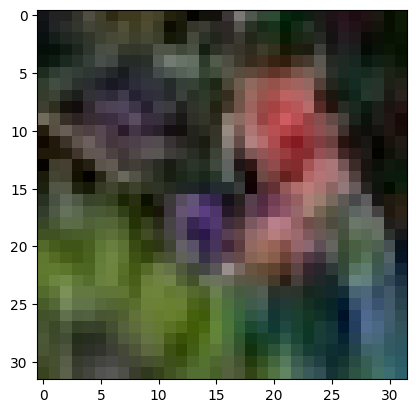

Dataset file with the same metadata found in datasets.


Processing chunks: 100%|██████████| 12/12 [00:01<00:00,  6.45it/s]


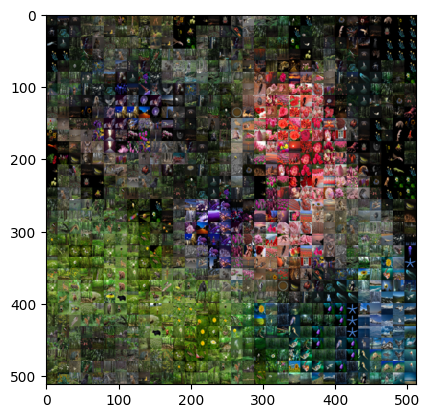

Dataset file with the same metadata found in datasets.


Processing chunks: 100%|██████████| 12/12 [00:02<00:00,  4.55it/s]


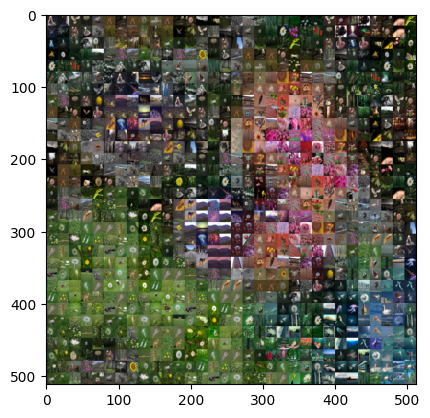

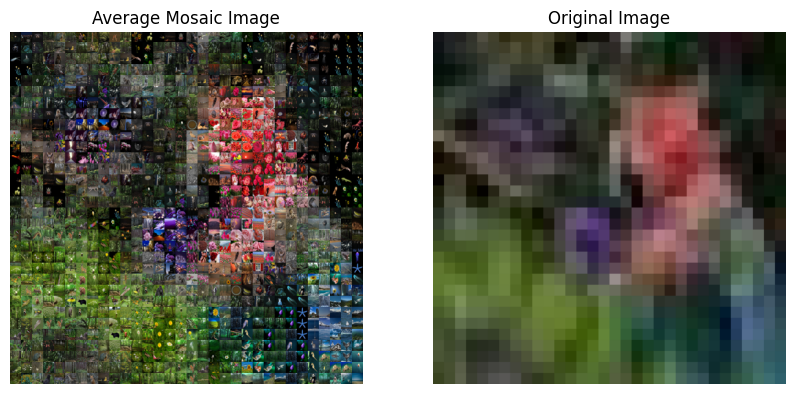

ME: 23.045536041259762
MSE: 24.885376754977198


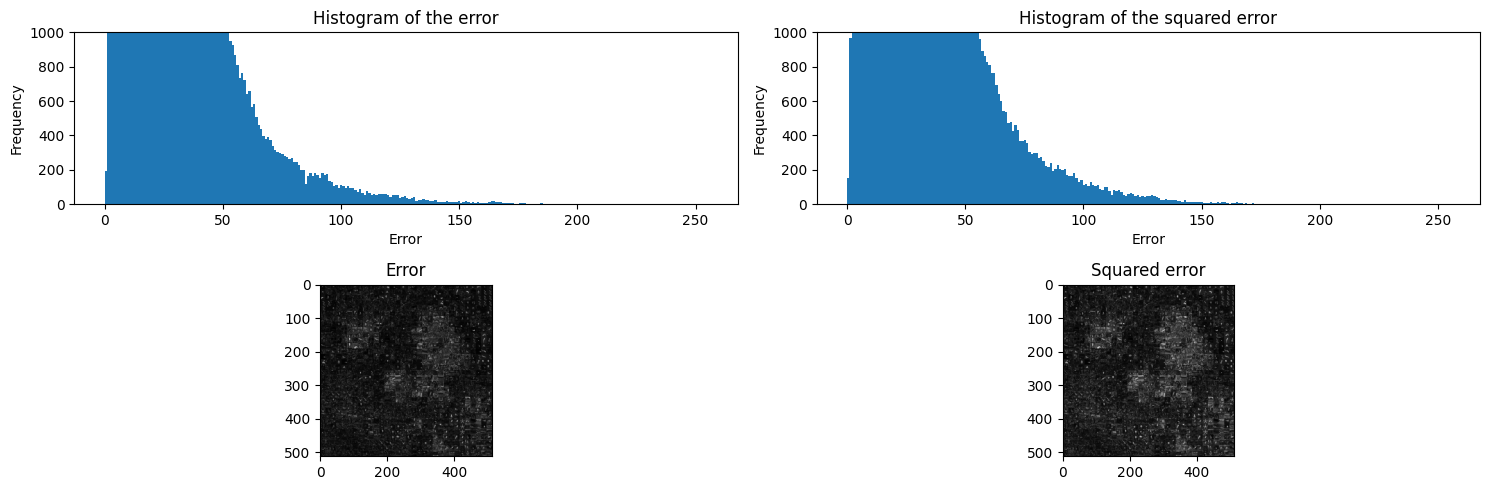

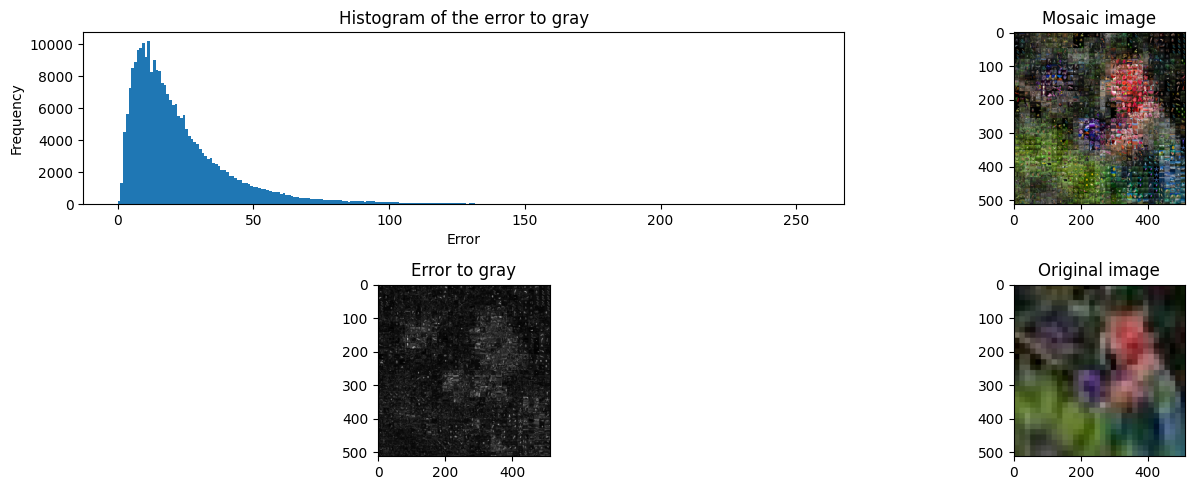

SSI: 0.22541264947855186
Points: (21, [10, 10, 1])


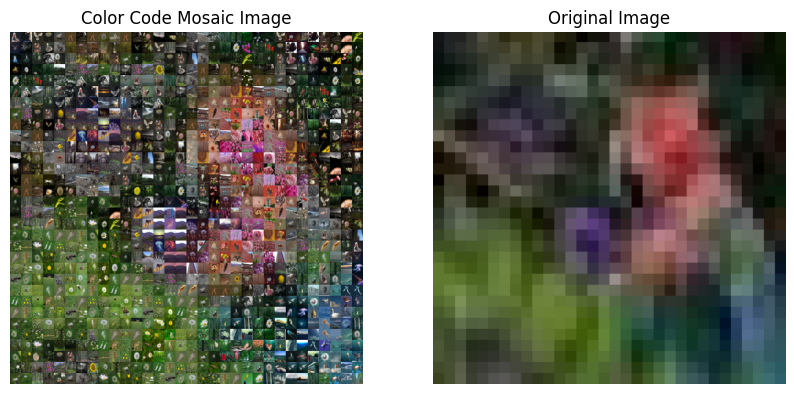

ME: 28.446628570556648
MSE: 29.06546420617623


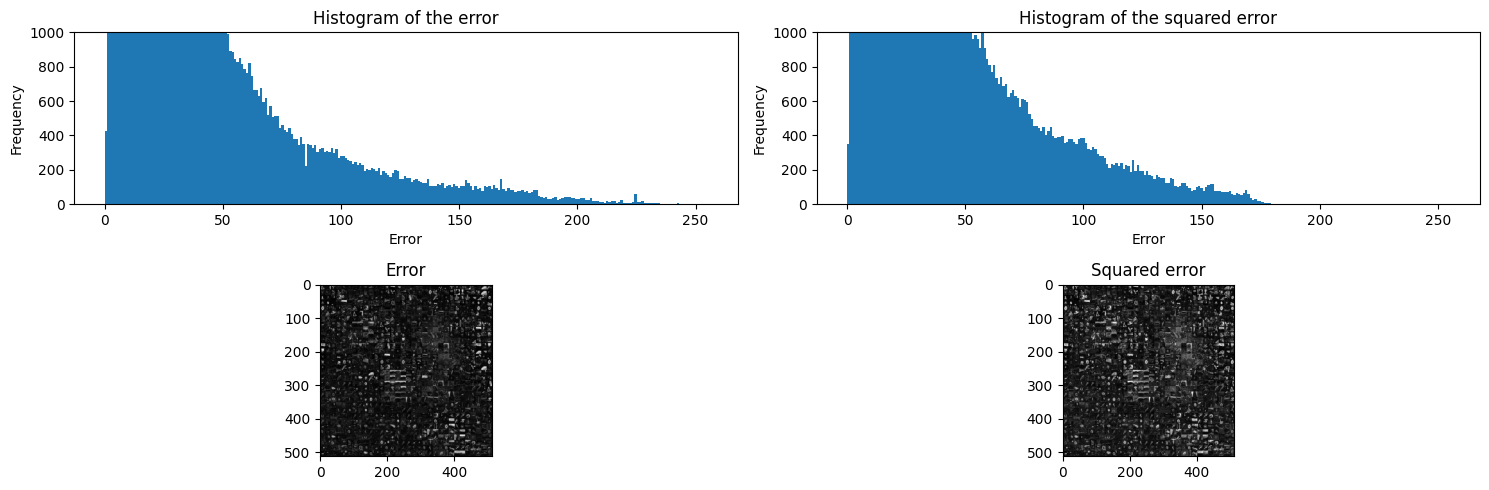

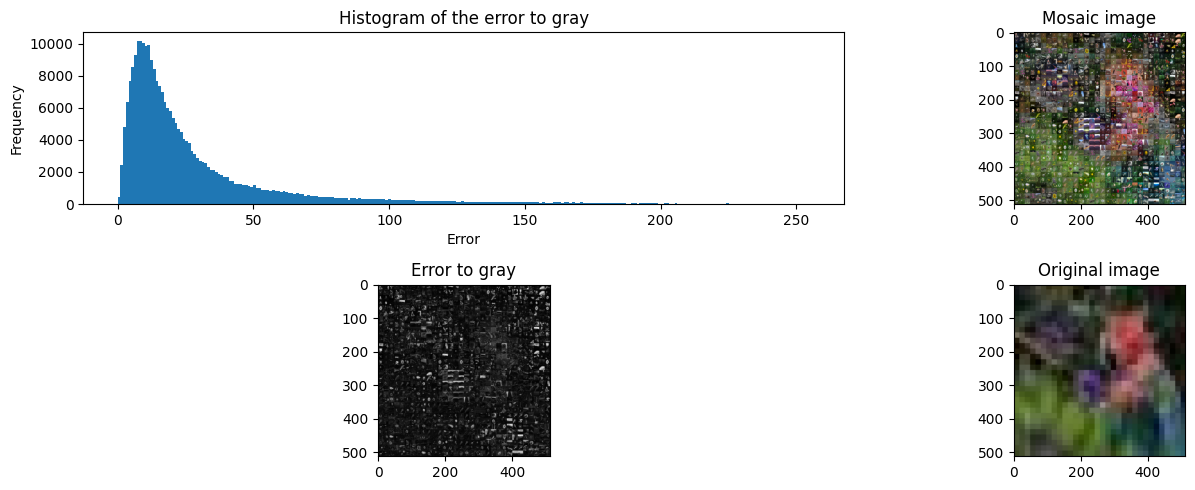

SSI: 0.19573282839963382
Points: (21, [10, 10, 1])


In [9]:
mosaik_image_paths = [
    # Path("test_images/", "icon_resized.jpg"),
    # Path("test_images/", "icon2_resized.jpg"),
    # Path("test_images/", "icon3_resized.jpg"),
    # Path("test_images/", "icon4_resized.jpg"),
    Path("test_images/", "icon4_32.jpg"),
    # Path("test_images/", "rakete_resized.jpg"),
]


image = Image.open(mosaik_image_paths[0])
plt.imshow(image)
plt.show()

average_preprocessor = AveragePreprocessor()
average_preprocessor.resize_shape = [16, 16]
average_preprocessor.generate_dataset_file(
    Path("data"), Path("datasets"), False, False
)

average_mosaic_generator = AverageMosaikGenerator(data_processor=average_preprocessor)
average_mosaic_generator.radius = 4
average_mosaik_images = average_mosaic_generator.create_mosaic_image(
    image_paths=mosaik_image_paths,
    color_correction=0,
    out_dir_path=Path("output"),
    show_images=True,
    save_images=True
)



colormap = SpecialColorMap838()
colormap.create_color_map_auto(8, 3, 8)

color_coder = ColorCoder(colormap)

color_code_preprocessor = ColorCodePreprocessor(
    threshold=0.2,
    color_coder=color_coder,
    dataset_file_path=Path("test.json"),
    resize_shape=[16, 16]
)
color_code_preprocessor.generate_dataset_file(
    data_dir=Path("data"),
    out_dir=Path("datasets"),
    generate_data_set=False,
    augment=False
)

color_code_mosaic_generator = ColorCodeMosaikGenerator(data_processor=color_code_preprocessor)
color_code_mosaic_generator.radius = 4
color_code_mosaik_images = color_code_mosaic_generator.create_mosaic_image(
    image_paths=mosaik_image_paths,
    color_correction=0,
    out_dir_path=Path("output"),
    show_images=True,
    save_images=True
)


metrik = Metrik()

for i, (average_image, color_code_image) in enumerate(zip(average_mosaik_images, color_code_mosaik_images)):
    original_image = Image.open(mosaik_image_paths[i])
    original_image = np.array(original_image)
    original_image_plot = np.repeat(
        np.repeat(original_image, 32, axis=0), 32, axis=1
    )


    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(Image.fromarray(average_image.astype(np.uint8)))
    axs[0].set_title("Average Mosaic Image")
    axs[0].axis("off")
    axs[1].imshow(Image.fromarray(original_image_plot.astype(np.uint8)))
    axs[1].set_title("Original Image")
    axs[1].axis("off")
    plt.show()
    score = metrik.get_mosaic_image_score(
        original_image=original_image,
        mosaic_image=average_image,
        small_image_size=(16, 16),
        kernel_size = 10
    )
    print(f"Points: {score}")

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(Image.fromarray(color_code_image.astype(np.uint8)))
    axs[0].set_title("Color Code Mosaic Image")
    axs[0].axis("off")
    axs[1].imshow(Image.fromarray(original_image_plot.astype(np.uint8)))
    axs[1].set_title("Original Image")
    axs[1].axis("off")
    plt.show()
    score = metrik.get_mosaic_image_score(
        original_image=original_image,
        mosaic_image=color_code_image,
        small_image_size=(16, 16),
        kernel_size = 10
    )
    print(f"Points: {score}")



Mosaic: [[[50. 70.  5.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
Error normal [[[50. 70.  5.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
Error normal mean [41.66666667  0.          0.          0.          0.          0.
  0.          0.          0.        ]
Error squared [[[2500. 4900.   25.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]

 [[   0.    0.    0.]
  [   0.    0.    0.]
  [   0.    0.    0.]]]
Error squared mean [49.74937186  0.          0.          0.          0.          0.
  0.          0.          0.        ]
Error cubic [[[1.25e+05 3.43e+05 1.25e+02]
  [0.00e+00 0.00e+00 0.00e+00]
  [0.00e+00 0.00e+00 0.00e+00]]

 [[0.00e+00 0.00e+00 0.00e+00]
  [0.00e+00 0.00e+00 0.00e+00]
  [0.00e+00 0.00e+00 0.00e+00]]

 [[0.00e+00 0.00

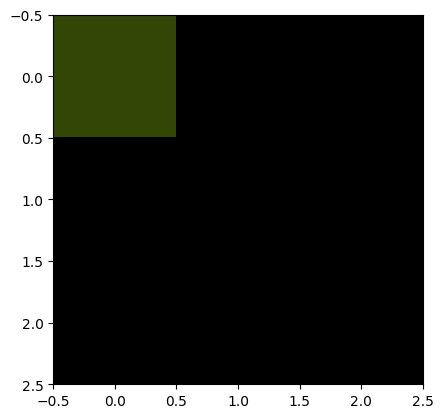

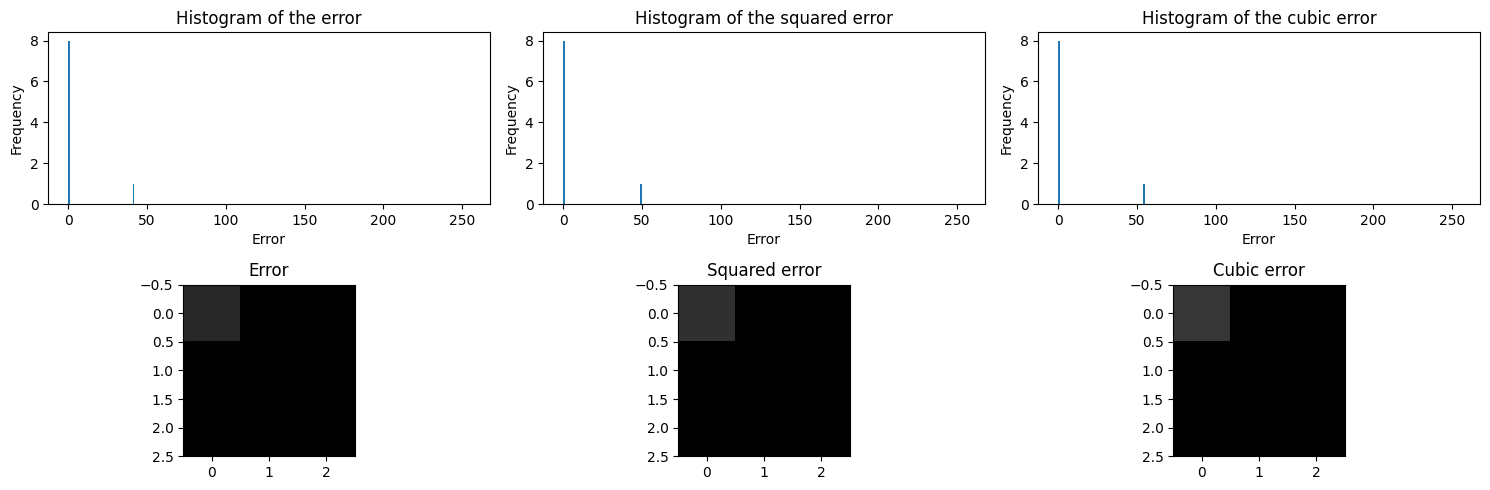

In [10]:
original_image = np.zeros((3, 3, 3))
mosaic_image = np.zeros((3, 3, 3))
mosaic_image[0, 0] = [50, 70, 5]


error = np.abs((original_image - mosaic_image))
error_normal = np.mean(error, axis=-1)
error_squared = error[:, :, :] ** 2
error_squared_mean = np.sqrt(np.abs(np.mean(error_squared, axis=-1)))
error_squared_mean = np.clip(error_squared_mean, 0, 255)
error_cubic = error ** 3
error_cubic_mean = np.cbrt(np.abs(np.mean(error_cubic, axis=-1)))
error_cubic_mean = np.clip(error_cubic_mean, 0, 255)


print(f"Mosaic: {mosaic_image}")
print(f"Error normal {error}")
print(f"Error normal mean {error_normal.ravel()}")
print(f"Error squared {error_squared}")
print(f"Error squared mean {error_squared_mean.ravel()}")
print(f"Error cubic {error_cubic}")
print(f"Error cubic mean {error_cubic_mean.ravel()}")

plt.imshow(Image.fromarray(mosaic_image.astype(np.uint8)))
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 5))
axes[0, 0].hist(error_normal.ravel(), bins=256, range=(0, 255))
axes[0, 0].set_title('Histogram of the error')
axes[0, 0].set_xlabel('Error')
axes[0, 0].set_ylabel('Frequency')
axes[1, 0].imshow(error_normal, cmap='gray', vmin=0, vmax=255)
axes[1, 0].set_title('Error')
axes[0, 1].hist(error_squared_mean.ravel(), bins=256, range=(0, 255))
axes[0, 1].set_title('Histogram of the squared error')
axes[0, 1].set_xlabel('Error')
axes[0, 1].set_ylabel('Frequency')
axes[1, 1].imshow(error_squared_mean, cmap='gray', vmin=0, vmax=255)
axes[1, 1].set_title('Squared error')
axes[0, 2].hist(error_cubic_mean.ravel(), bins=256, range=(0, 255))
axes[0, 2].set_title('Histogram of the cubic error')
axes[0, 2].set_xlabel('Error')
axes[0, 2].set_ylabel('Frequency')
axes[1, 2].imshow(error_cubic_mean, cmap='gray', vmin=0, vmax=255)
axes[1, 2].set_title('Cubic error')
plt.tight_layout()
plt.show()

In [11]:
mosaic_image = color_code_mosaik_images[4]
blur_image = metrik._boxblur_image(mosaic_image, kernel_size=10)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.fromarray(mosaic_image.astype(np.uint8)))
axes[0].set_title("Mosaic Image")
axes[0].axis("off")
axes[1].imshow(Image.fromarray(blur_image.astype(np.uint8)))
axes[1].set_title("Blurred Mosaic Image")
axes[1].axis("off")
plt.tight_layout()
plt.show()

IndexError: list index out of range

In [ ]:
avg_time = metrik.calc_speed(
    average_mosaic_generator.create_mosaic_image,
    5,
    mosaik_image_paths,
    0,
    Path("output"),
    False,
    False,
)

print(f"Average Mosaic Generator Time: {avg_time}")


color_code_time = metrik.calc_speed(
    color_code_mosaic_generator.create_mosaic_image,
    5,
    mosaik_image_paths,
    0,
    Path("output"),
    False,
    False,
)

print(f"Color Code Mosaic Generator Time: {color_code_time}")

print(f"Faster: {avg_time / color_code_time}")

In [ ]:
image = np.zeros((15, 15, 3))
image[2:6, :] = [255, 255, 255]
image[9:13, :] = [255, 255, 255]

image = Image.fromarray(image.astype(np.uint8))

image_blurr = image.filter(ImageFilter.BoxBlur(1))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("BoxBlur Filter 3x3")
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(image_blurr)
axs[1].set_title("Blurred Image")
axs[1].axis("off")


In [ ]:
image_red_green = np.zeros((15, 15, 3)) 
image_red_green[:, :7] = [255, 0, 0]
image_red_green[:, 7:] = [0, 255, 0]

image_red_green = Image.fromarray(image_red_green.astype(np.uint8))
blur_image_red_green = image_red_green.filter(ImageFilter.BoxBlur(50))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("BoxBlur Filter 3x3")
axs[0].imshow(image_red_green)
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(blur_image_red_green)
axs[1].set_title("Blurred Image")
axs[1].axis("off")
plt.show()

print(np.mean(image_red_green, axis=(0, 1)))
image_mean = np.zeros((15, 15, 3))
image_mean[:, :] = np.mean(image_red_green, axis=(0, 1)).astype(int)
image_mean = Image.fromarray(image_mean.astype(np.uint8))
plt.imshow(image_mean)  
plt.show()

Idee:

- Einleitung und Motivation
    - Motivation: 
        - Webanwendungen gibt noch keine (wie kann man das prüfen) Anwendung die Fotomosaikbilder Pixel by Pixel erstellt stattdessen werden die Bilder hochskaliert und dann erstellt, was aber nicht immer das ist was man möchte. Die Arbeit soll explorativ sein und in dieser Richtung verschiedene Methoden und Algorithmen entwickeln, die genau das umsetzen können und diese miteinander vergleichen

- Stellen einer Forschungsfrage und Erstellung von Anforderungen (funktional und nicht-funktional)
    - Anforderungen:
        - Funktional: 
            - Eingabebild zu Mosaikbild umwandelbar (Bewertung: 0 - 1)
            - Speicherung der Bilder notwendig (Bewertung: 0 - 1)
            - Anzeige der Bilder notwendig (Bewertung: 0 - 1)
        - Nicht-funktional:
            - Ästhetik des Mosaikbildes (Bewertung: 0 - 10 mit Squared Error über die farbliche Abweichung; 0 minimal, 10 maximale mögliche Abweichung (mathematisch) und dann eine Lineare Skala erstellen; Wenn man hier noch die andere Methode mit dem "Gamma" reinnimmt statt eine Farbkorrektur zu implementieren, dann sollte man hier vielleicht den Quotienten es der Farbabweichung und der Varianz der kleinen Bilder als Metrik verwenden)
            - Laufzeit des Algorithmus (Bewertung: 0 - 10 Wie kann man hier minimal und maximal definieren?)
            - Speicherbedarf des Algorithmus (???)
            - Parametrisierung des Algorithmus (Bewertung: 0 - 10 Anzahl der Parameter als Metrik; Wie wird min und max definiert)
            - Anzahl der Bilder die notwendig sind, um ein Mosaikbild zu erstellen (Bewertung: 0 - 10; Wie wird min und max definiert)
    
- Erstellung von Metriken und Bewertungen für die Anforderugen
    - Beschreibung der Metriken und wofür sie verwendet werden


- Threoretische Grundlagen 
    - Was gibt es noch für Algorithmen (Einordnung)
    - Grundlagen zu Bewertung von Methoden durch Entscheidungsmatrizen
    - Grundlagen zu Komplexitäten von verwendeten Algorithmen (wie KD-Baum, etc.)
    - Grundlagen zu Farbräumen und Farbmodellen mit dem Fokus auf RGB und HSV
    

Beschreibung der Methoden
    - Bei der Beschreibung der Methoden sollte man von großen ins kleine gehen und Pseudo-Code, mathematische Formeln, Flussdiagramme und Bilder verwenden um zu illustrieren, wie die Methoden funktionieren. Also erstmal die grobe Struktur beschreiben und dann in die einzelnen Teile rein gehen und auch erklären, welche Algorithmen mit welcher Komplexität verwendet werden und warum.

Vergleich der Methoden
    - Der Vergleich der Methoden läuft auf der Grundlage der Anforderungen und Metriken in einer Entscheidungsmatrix ab.